<a href="https://colab.research.google.com/github/SebastianSanchez5/DataAnalysis/blob/main/Sebastian_Sanchez_Assignment_1_NYPD_Analysis_DwD_Summer2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYPD Crime Reports Dataset

You are asked to analyze the dataset with all the valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2024.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

It is a big dataset with ~9 million crimes reported to NYPD.

## Attribute Description

Below you can find the description of the attributes, and their datatypes.

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| JURISDICTION_CODE	| | smallint(6)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| BORO_NM | The name of the borough in which the incident occurred | enum('BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND')
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PATROL_BORO | |	enum('PATROL BORO BRONX','PATROL BORO BKLYN SOUTH','PATROL BORO BKLYN NORTH','PATROL BORO MAN SOUTH','PATROL BORO MAN NORTH','PATROL BORO QUEENS NORTH','PATROL BORO QUEENS SOUTH','PATROL BORO STATEN ISLAND')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| SUSP_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| VIC_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| SUSP_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| VIC_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| SUSP_SEX  | |		enum('M','F')
| VIC_SEX  | |	enum('M','F','E','D')
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double


### Auxiliary Tables

We also have three auxiliary tables `jurisdiction_codes`, `offense_codes`, `penal_codes`, which provide descriptions for the `JURISDICTION_CODE`, `KY_CD`, and `PD_CD` attributes of the main table.




Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf



## MySQL and BigQuery Databases

For your convenience, the dataset is stored in the `nypd` database on the MySQL Server `db.ipeirotis.org`. You can connect and see the dataset using your standard username and password (`student`, `dwdstudent2015`).

In addition, the database is also available in BigQuery under the tables `nyu-datasets.nypd_complaints.nypd` and `nyu-datasets.nypd_complaints.offense_codes`

In [1]:
!sudo pip3 install  -U -q  PyMySQL sqlalchemy google-cloud-bigquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 869.2 kB/s eta 0:00:00


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
import seaborn as sns
import matplotlib as plt

In [4]:
# Code to connect to BigQuery
from google.colab import auth
from google.cloud import bigquery

# This command will create a popup asking you to login to your Google account
auth.authenticate_user()

# IMPORTANT: Replace with your GCP project ID
project_id = 'ipeirotis-hrd'
bq = bigquery.Client(project=project_id)

MessageError: Error: credential propagation was unsuccessful

In [5]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student',
    password='dwdstudent2025',
    host = 'db.ipeirotis.org',
    port=3306,
    db='nypd',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Questions

You are asked to analyze the dataset and provide answers for the questions below. You can answer the questions using Python, SQL, or a combination of them.

## Question 1: Composition of crimes

* **Question 1a**: How many total reported crimes are in the dataset?
* **Question 1b**: Analyze the column `LAW_CAT_CD` and provide the breakdown of the reported crimes among `FELONY`,`MISDEMEANOR`, and `VIOLATION`, i.e., report the number of felonies, misdemeanors, and violations. Create a bar plot showing the values across the three crime types.
* **Question 1c**: Across **felonies**, report the number of crimes, broken down by  offense description (as reported in the `OFNS_DESC` column of the `offense_codes` table). Create a bar plot showing the frequency of the top-10 offense descriptions for the felonies.

In [6]:
# Question 1a: How many total reported crimes are in the dataset?

# This is how you query the dataset on MySQL
sql = '''
	SELECT COUNT(*) AS reports
	FROM nypd.nypd
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

display(df)

reports
0  9489736

In [ ]:
# This is how you can query the BigQuery database:

sql = '''
SELECT COUNT(*) AS reports
FROM nyu-datasets.nypd_complaints.nypd
'''

df = bq.query(sql).to_dataframe()

display(df)

In [8]:
# Question 1b: Analyze the column LAW_CAT_CD and report the number of felonies, misdemeanors, and violations.

sql = '''
Select LAW_CAT_CD, count(*) as reports
from nypd.nypd
group by LAW_CAT_CD

'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

LAW_CAT_CD  reports
0       FELONY  2979762
1  MISDEMEANOR  5215578
2    VIOLATION  1294396

<Axes: xlabel='LAW_CAT_CD'>

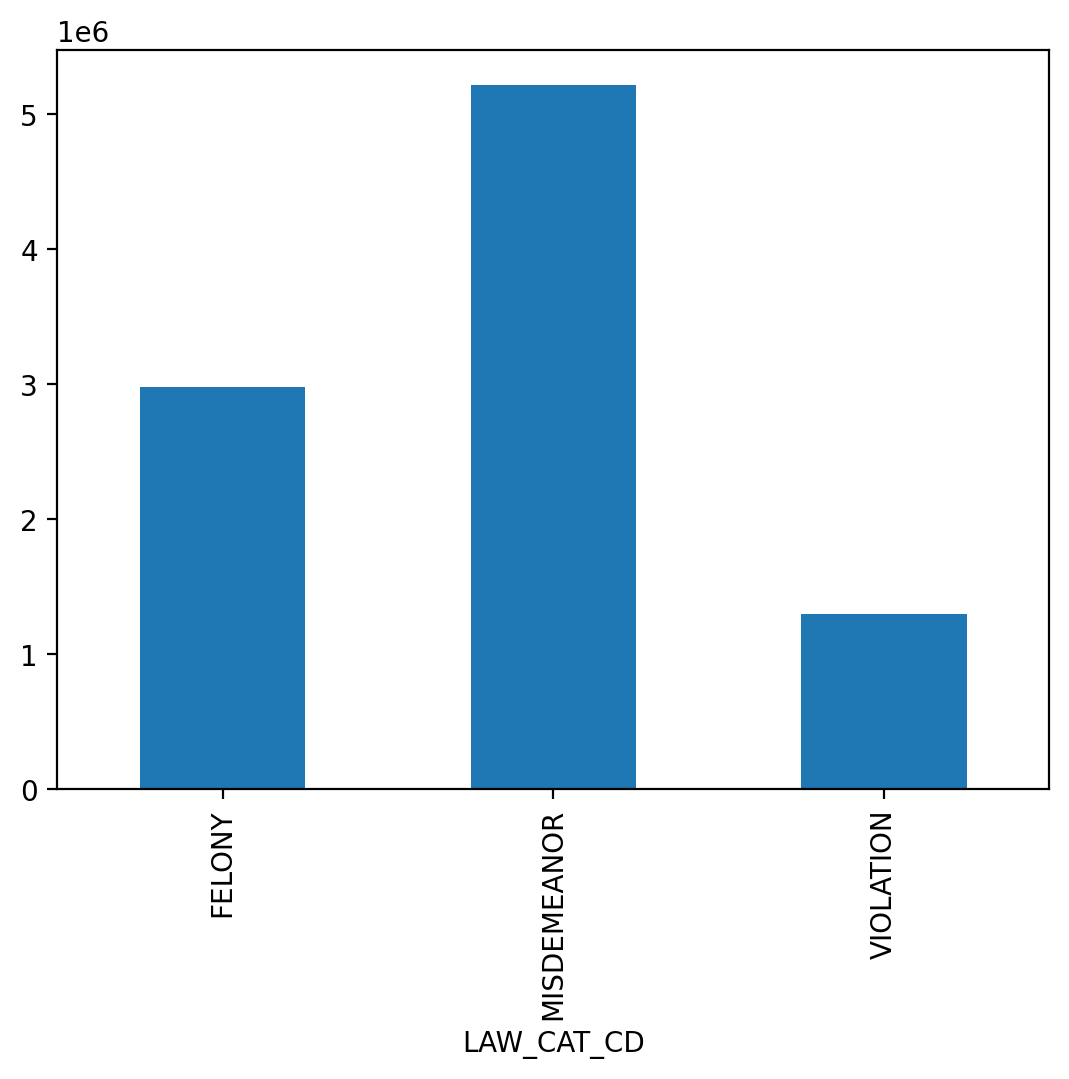

In [9]:
# Create a bar plot showing the values across the three crime types.
df.plot(
kind='bar', x='LAW_CAT_CD', y='reports', legend=False
)

In [31]:
# Question 1c: Across felonies, report the number of crimes, broken down by offense description (as reported in the OFNS_DESC column)

sql = '''
Select LAW_CAT_CD, OFNS_DESC, count(*) as reports
From nypd.nypd Join nypd.offense_codes on nypd.nypd.KY_CD = nypd.offense_codes.KY_CD
where LAW_CAT_CD = 'FELONY'
group by OFNS_DESC
order by reports desc
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

LAW_CAT_CD                         OFNS_DESC  reports
0      FELONY                     GRAND LARCENY   831589
1      FELONY                    FELONY ASSAULT   393251
2      FELONY                           ROBBERY   331377
3      FELONY                          BURGLARY   310122
4      FELONY           MISCELLANEOUS PENAL LAW   239227
5      FELONY    GRAND LARCENY OF MOTOR VEHICLE   187731
6      FELONY    CRIMINAL MISCHIEF & RELATED OF   183409
7      FELONY                   DANGEROUS DRUGS   108478
8      FELONY                           FORGERY    95662
9      FELONY                 DANGEROUS WEAPONS    92737
10     FELONY                       THEFT-FRAUD    90450
11     FELONY                              RAPE    28029
12     FELONY                        SEX CRIMES    23588
13     FELONY                             ARSON    20210
14     FELONY     POSSESSION OF STOLEN PROPERTY    17878
15     FELONY      NYS LAWS-UNCLASSIFIED FELONY    11839
16     FELONY   MURDER & NON-NEGL. MANSLAUGHTER     7975
17     FELONY     KIDNAPPING & RELATED OFFENSES     3499
18     FELONY     CHILD ABANDONMENT/NON SUPPORT      826
19     FELONY  OTHER STATE LAWS (NON PENAL LAW)      455
20     FELONY   PROSTITUTION & RELATED OFFENSES      382
21     FELONY         CANNABIS RELATED OFFENSES      325
22     FELONY    HOMICIDE-NEGLIGENT,UNCLASSIFIE      260
23     FELONY                          GAMBLING      191
24     FELONY        HOMICIDE-NEGLIGENT-VEHICLE      125
25     FELONY      INTOXICATED/IMPAIRED DRIVING       88
26     FELONY    OFFENSES AGAINST PUBLIC ADMINI       13
27     FELONY     OFF. AGNST PUB ORD SENSBLTY &       12
28     FELONY      ASSAULT 3 & RELATED OFFENSES       11
29     FELONY                          ABORTION        7
30     FELONY                     HARRASSMENT 2        6
31     FELONY                 CRIMINAL TRESPASS        2
32     FELONY                            FRAUDS        2
33     FELONY               ADMINISTRATIVE CODE        1
34     FELONY                     PETIT LARCENY        1
35     FELONY    INTOXICATED & IMPAIRED DRIVING        1
36     FELONY   OTHER OFFENSES RELATED TO THEFT        1
37     FELONY       OFFENSES AGAINST THE PERSON        1
38     FELONY         NEW YORK CITY HEALTH CODE        1

<Axes: xlabel='OFNS_DESC'>

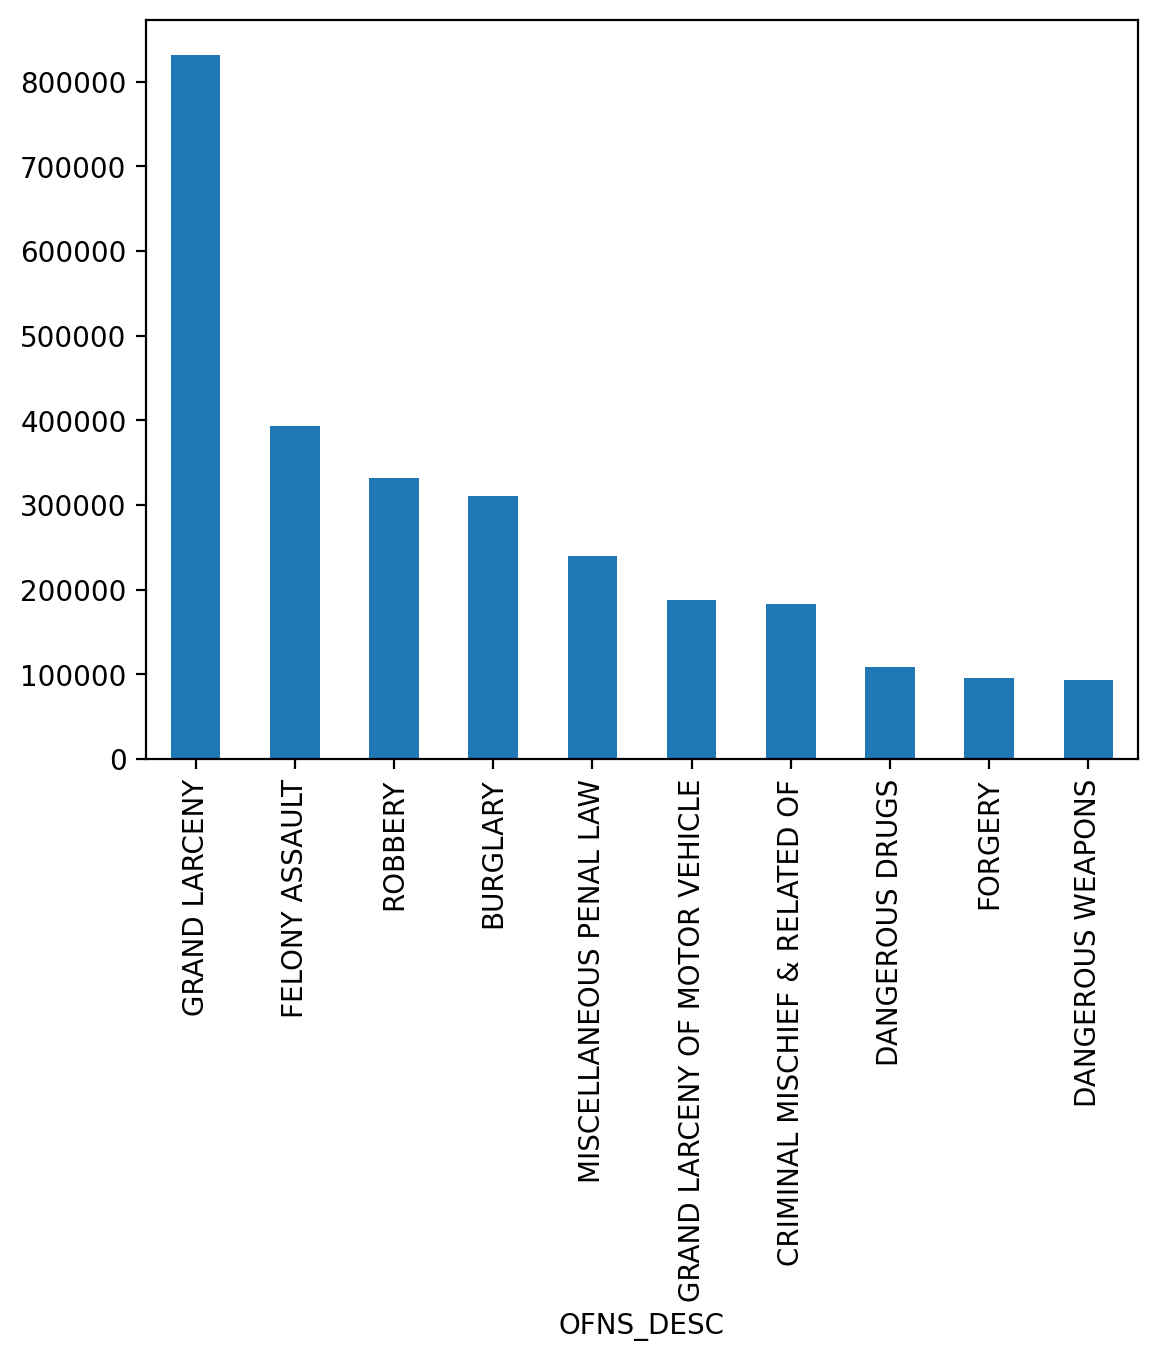

In [32]:
# Create a bar plot showing the frequency of the top-10 offense descriptions
df.head(10).plot(
kind='bar', x='OFNS_DESC', y='reports', legend=False
)

## Question 2: Is crime increasing or decreasing in NYC?

Use the column `CMPLNT_FR` that reports the date/time of the crime. You are asked to analyze the crimes that happened between January 1st 2006 and December 31st 2024.

* **Question 2a**: Create a plot that shows the *total* number of **all** reported crimes *per year*.

* **Question 2b**: Create a plot that shows the *total* number of **all** reported crimes *per month*  (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, ..., Dec-2024).



**Hint 1**: Be aware that comparisons with dates in MySQL are tricky. You will want to use the format `YYYY-MM-DD` for a date (e.g., "2006-01-01"), so that it gets properly interpreted by MySQL.

**Hint 2**: You can use the `YEAR(CMPLNT_FR)` to extract the year. You can use the `DATE_FORMAT(CMPLNT_FR, '%Y-%m-01')` command in SQL to truncate the field `CMPLNT_FR` and set it to the first day of the month.

**Hint 3**: Alternatively, you can use the  `resample` command in Pandas, to compute statistics on a per-month and per-year basis. If you use resample, remember that you need to make the date column to be the "index" of the dataframe using the `.set_index(CMPLNT_FR)` command (assuming `CMPLNT_FR` is the name of the column with the date) to create a new dataframe with the date being the infex. Be cautious if you get back from SQL the raw datetimes, and  understand the difference between `resample(...).sum()` and `resample(...).mean()`. The `mean()` vs `sum()` can generate very different results, especially when the timestamp variable has a very fine granularity (as happens in our case with `CMPLNT_FR`).

In [48]:
# Question 2a: Create a plot that shows the total number of all reported crimes per year.
sql = '''
select YEAR(CMPLNT_FR) as crime_year, count(*) as reports
from nypd.nypd
where YEAR(CMPLNT_FR) between 2006 and 2024
group by crime_year
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

crime_year  reports
0         2006   528145
1         2007   535498
2         2008   528973
3         2009   511223
4         2010   510403
5         2011   498946
6         2012   505099
7         2013   496256
8         2014   492537
9         2015   479109
10        2016   478729
11        2017   468494
12        2018   462863
13        2019   459494
14        2020   414076
15        2021   450080
16        2022   530846
17        2023   552463
18        2024   565137

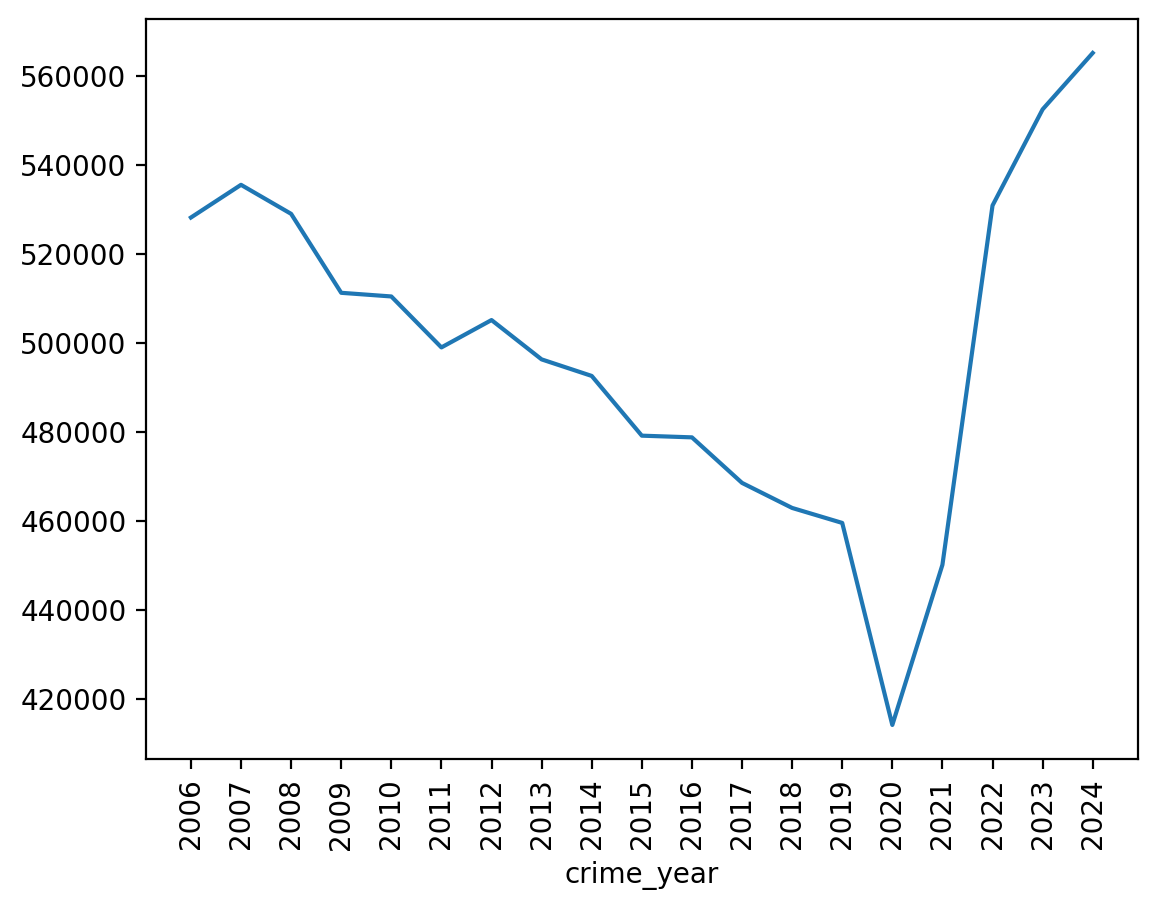

In [60]:
# Create a plot that shows the total number of all reported crimes per year.
df.plot(
kind='line', x='crime_year', y='reports', legend=False
)

# Set x-axis ticks to show all years
plt.xticks(df['crime_year'])

# rotate for better visibility
plt.xticks(rotation=90)

plt.show()

In [63]:
# Question 2b: Create a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007,.. Dec-2024).

sql = '''
SELECT DATE_FORMAT(CMPLNT_FR, '%b-%Y') AS crime_month, YEAR(CMPLNT_FR) as crime_year_num, MONTH(CMPLNT_FR) as crime_month_num, COUNT(*) AS reports
FROM nypd.nypd
WHERE CMPLNT_FR BETWEEN '2006-01-01' AND '2024-12-31'
GROUP BY crime_month, crime_year_num, crime_month_num
ORDER BY crime_year_num, crime_month_num
'''

with engine.connect() as connection:
        df = pd.read_sql(text(sql), con=connection)

df

crime_month  crime_year_num  crime_month_num  reports
0      Jan-2006            2006                1    43856
1      Feb-2006            2006                2    36827
2      Mar-2006            2006                3    43449
3      Apr-2006            2006                4    41898
4      May-2006            2006                5    45373
..          ...             ...              ...      ...
223    Aug-2024            2024                8    49671
224    Sep-2024            2024                9    48247
225    Oct-2024            2024               10    49702
226    Nov-2024            2024               11    45941
227    Dec-2024            2024               12    39911

[228 rows x 4 columns]

<Axes: xlabel='crime_month'>

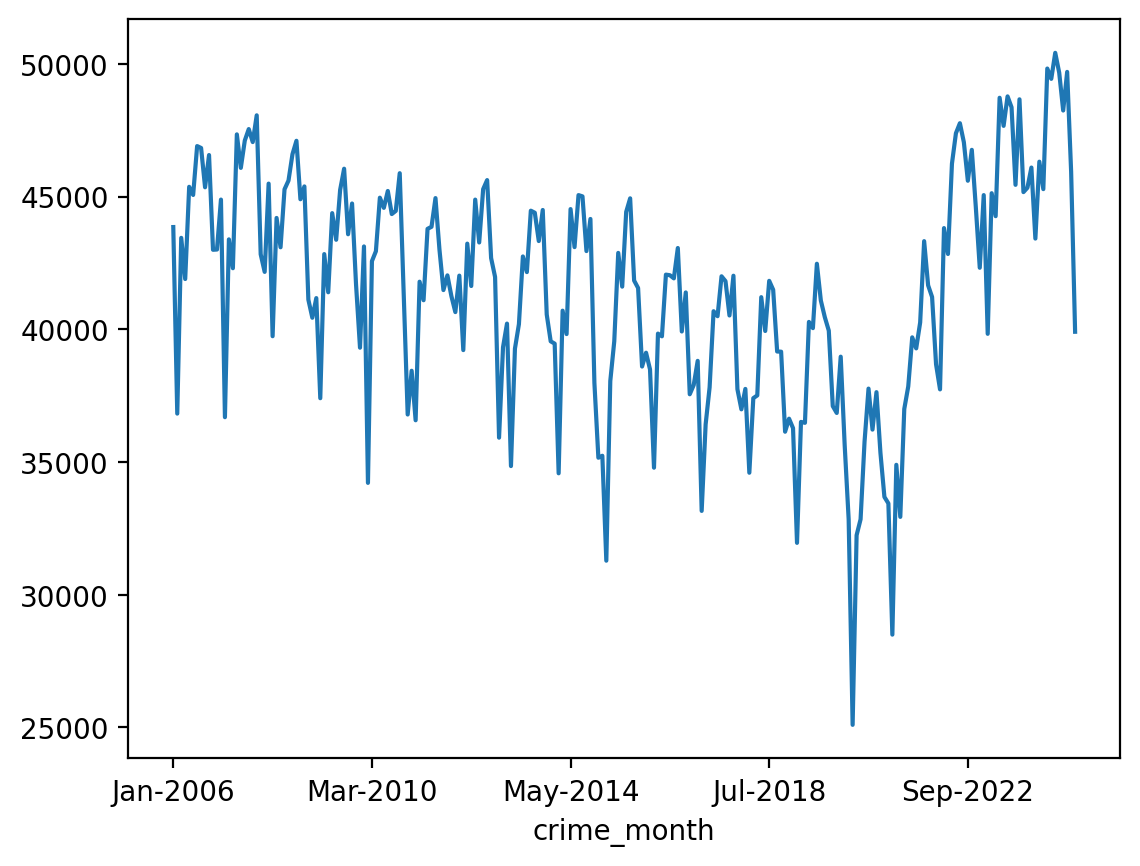

In [64]:
# Question 2b: Create a plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, ... Dec-2024).
df.plot(
kind='line', x='crime_month', y='reports', legend=False
)

## Question 3: Analysis of the "Big-7" felonies

The NYPD calls the following types of felonies as the "big-7" crimes, as they tend to affect most the quality of life:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE
* RAPE
* MURDER & NON-NEGL. MANSLAUGHTER


Focus on the big-7 felonies. Report the number of these crimes over time, from 2006 till 2024, **broken down by type of felony**. Focus on reporting the **total** number of crimes per category, on a **per month** basis (Jan-06, Feb-06, ... Dec-24). Generate the associated plot with the number of big-7 felonies over time. You will probably want to make the y-axis logarithmic as the different felonies have different orders of magnitude.

**Hint 1**: The type of felony is included in the `OFNS_DESC` column of the `offense_codes` table and the key for the offense is the `KY_CD` attribute in the main table. You can use the `IN` command in SQL to limit your results to these offenses, or use an `OR` clause. Alternatively, you can use the [`.isin()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isin.html) command in Pandas.

**Hint 2**: If you would like to move the legend outside the plot, you can use the following command: `df.plot(...).legend(bbox_to_anchor=(1, 0.75))`. The two values for the parameter `bbox_to_anchor` describe the x/y location of the legend, compared to the plot. Experiment with different values to understand the effect.


In [73]:
sql = '''
SELECT
    nypd.offense_codes.OFNS_DESC,
    DATE_FORMAT(nypd.nypd.CMPLNT_FR, '%Y-%m-01') AS crime_month,
    COUNT(*) AS reports
FROM
    nypd.nypd
JOIN
    nypd.offense_codes ON nypd.nypd.KY_CD = nypd.offense_codes.KY_CD
WHERE
    nypd.nypd.LAW_CAT_CD = 'FELONY'
    AND nypd.nypd.CMPLNT_FR BETWEEN '2006-01-01' AND '2024-12-31'
    AND nypd.offense_codes.OFNS_DESC IN (
        'GRAND LARCENY',
        'ROBBERY',
        'FELONY ASSAULT',
        'BURGLARY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'RAPE',
        'MURDER & NON-NEGL. MANSLAUGHTER'
    )
GROUP BY
    nypd.offense_codes.OFNS_DESC,
    crime_month
ORDER BY
    nypd.offense_codes.OFNS_DESC,
		crime_month;
'''

with engine.connect() as connection:
        df = pd.read_sql(text(sql), con=connection)

df

OFNS_DESC crime_month  reports
0     BURGLARY  2006-01-01     1944
1     BURGLARY  2006-02-01     1561
2     BURGLARY  2006-03-01     1869
3     BURGLARY  2006-04-01     1655
4     BURGLARY  2006-05-01     1944
...        ...         ...      ...
1591   ROBBERY  2024-08-01     1491
1592   ROBBERY  2024-09-01     1369
1593   ROBBERY  2024-10-01     1477
1594   ROBBERY  2024-11-01     1307
1595   ROBBERY  2024-12-01     1103

[1596 rows x 3 columns]

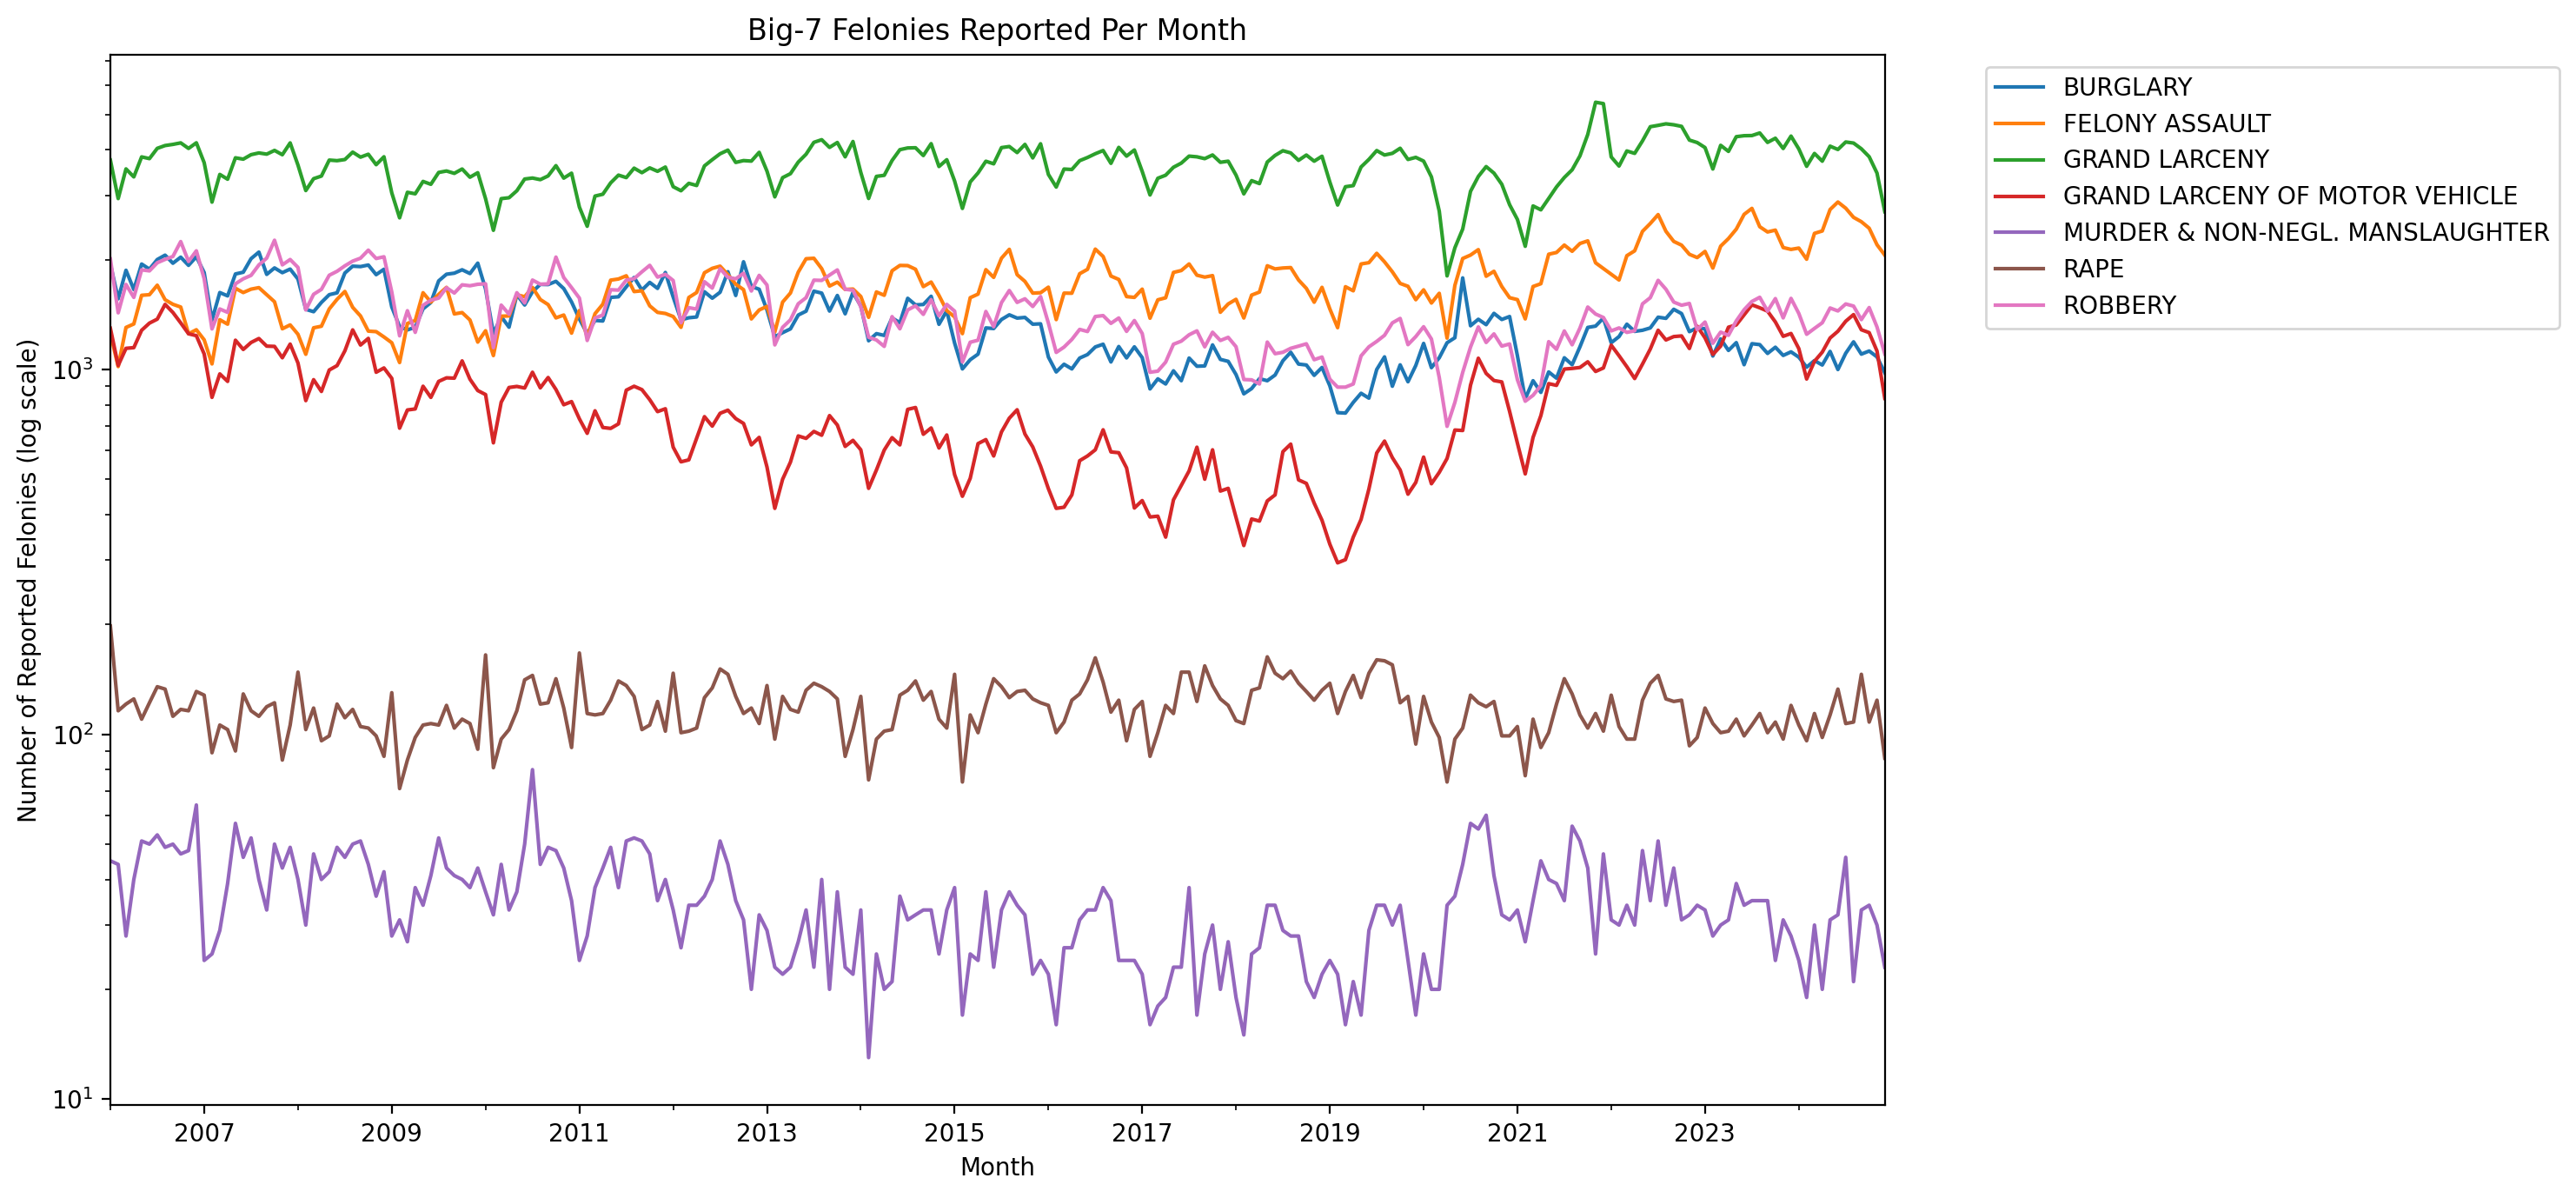

In [75]:
# prompt: plot table in the obove sell with one series for each of the distinct ofns_desc


# Pivot the dataframe to have OFNS_DESC as columns for plotting
df_pivot = df.pivot_table(index='crime_month', columns='OFNS_DESC', values='reports', fill_value=0)

# Convert the index to datetime for proper sorting
df_pivot.index = pd.to_datetime(df_pivot.index)

# Sort by index (date)
df_pivot = df_pivot.sort_index()

# Plotting with log scale on the y-axis
ax = df_pivot.plot(kind='line', figsize=(15, 7), logy=True)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Reported Felonies (log scale)")
ax.set_title("Big-7 Felonies Reported Per Month")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Question 4: Analyze the Big-7 felonies based on hour of the day.

You are now asked to break down the different big-7 felonies by hour of day. We only want to calculate statistics based on the time of the day (i.e., 24 data points per crime). You do *not* need to generate the time series from 2006 to 2024 with hourly granularity.

* **Question 4a**: Show the number of big-7 felonies, broken down by hour of day. (e.g., _8375 reported robberies at 5am_). Generate a plot with the results.

* **Question 4b**: Show the number of big-7 felonies, broken down by hour of day. To allow for easier comparison among felonies, **normalize** the data by dividing by the total incidents for each type of felony.  (e.g., _2.8% of the reported robberies happen at 5am_). Generate a bar plot with the results.


**Hint 1**: You can use the commands `HOUR()`  in SQL, to extract the hour.

**Hint 2**: When creating plots, you may prefer to put the plot for each columns of the dataframe in a separate plot. The option `subplots=True` for the `df.plot()` command provides that capability. (See [the related documentation](https://pandas.pydata.org/pandas-docs/stable/visualization.html#subplots).) If you use the `subplots=True`, you can also use the `layout=(num_rows, num_columns)` option to specify the number of rows (`num_rows`) and the number of columns (`num_columns`) to use for the grid arrangement.


In [80]:


sql = '''
SELECT
    HOUR(nypd.nypd.CMPLNT_FR) AS crime_hour,
    nypd.offense_codes.OFNS_DESC,
    COUNT(*) AS reports
FROM
    nypd.nypd
JOIN
    nypd.offense_codes ON nypd.nypd.KY_CD = nypd.offense_codes.KY_CD
WHERE
    HOUR(nypd.nypd.CMPLNT_FR) BETWEEN 0 AND 23
		AND nypd.nypd.LAW_CAT_CD = 'FELONY'
    AND nypd.offense_codes.OFNS_DESC IN (
        'GRAND LARCENY',
        'ROBBERY',
        'FELONY ASSAULT',
        'BURGLARY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'RAPE',
        'MURDER & NON-NEGL. MANSLAUGHTER'
    )
GROUP BY
    crime_hour,
    nypd.offense_codes.OFNS_DESC
ORDER BY
    nypd.offense_codes.OFNS_DESC,
		crime_hour
    ;
'''

with engine.connect() as connection:
        df_hourly = pd.read_sql(text(sql), con=connection)

df_hourly

crime_hour OFNS_DESC  reports
0             0  BURGLARY    10848
1             1  BURGLARY     9960
2             2  BURGLARY    10093
3             3  BURGLARY    10164
4             4  BURGLARY     9694
..          ...       ...      ...
163          19   ROBBERY    17800
164          20   ROBBERY    18843
165          21   ROBBERY    19585
166          22   ROBBERY    18770
167          23   ROBBERY    18377

[168 rows x 3 columns]

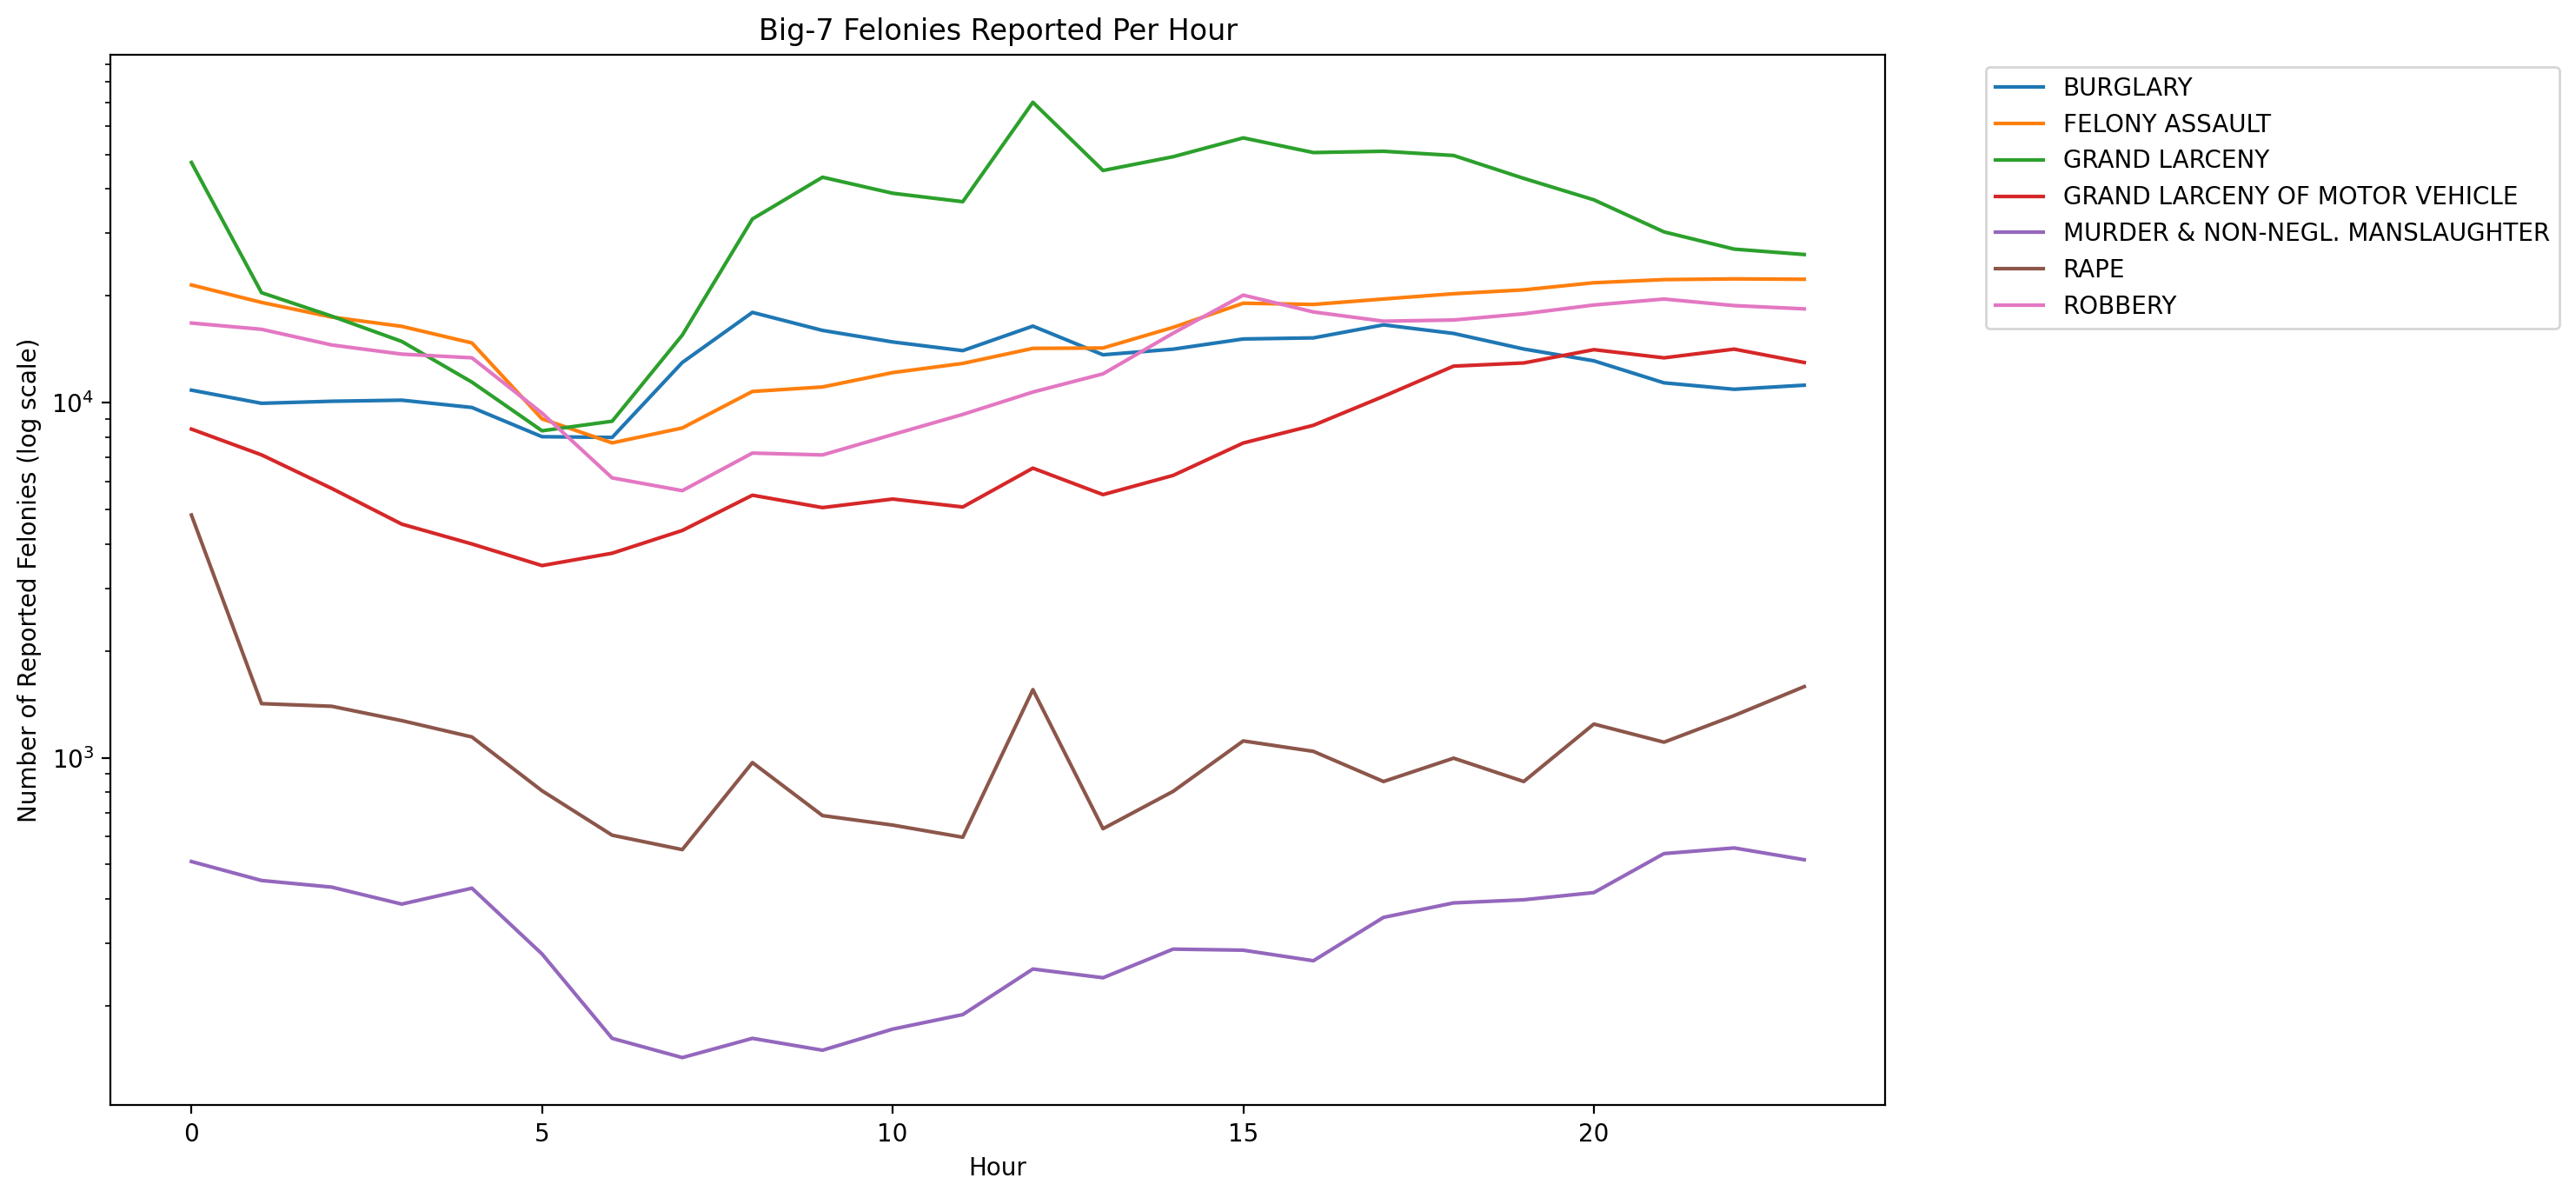

In [101]:
# Question 4a: Show the number of big-7 felonies, broken down by hour of day.
 # (e.g., 8375 reported robberies at 5am). Generate a plot with the results.

# Pivot the dataframe to have OFNS_DESC as columns for plotting
df_hourly_pivot = df_hourly.pivot_table(index='crime_hour', columns='OFNS_DESC', values='reports', fill_value=0)

# Convert the index to datetime for proper sorting
df_hourly.index = pd.to_datetime(df_hourly.index)

# Sort by index (hour)
df_hourly = df_hourly.sort_index()

# Plotting with log scale on the y-axis
ax = df_hourly_pivot.plot(kind='line', figsize=(15, 7), logy=True)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Reported Felonies (log scale)")
ax.set_title("Big-7 Felonies Reported Per Hour")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

In [115]:
# Question 4b: Show the number of big-7 felonies, broken down by hour of day.
# To allow for easier comparison among felonies, normalize the data by dividing
# by the total incidents for each type of felony. (e.g., 2.8% of the reported
# robberies happen at 5am). Generate a bar plot with the results.


# Create temporary table for hourly felony counts
sql_drop_hourly_felonies_temp_table = '''
DROP TEMPORARY TABLE IF EXISTS HourlyFelonies;
'''

sql_create_hourly_felonies_temp_table = '''
CREATE TEMPORARY TABLE HourlyFelonies AS
SELECT
    HOUR(nypd.nypd.CMPLNT_FR) AS crime_hour,
    nypd.offense_codes.OFNS_DESC,
    COUNT(*) AS reports
FROM
    nypd.nypd
JOIN
    nypd.offense_codes ON nypd.nypd.KY_CD = nypd.offense_codes.KY_CD
WHERE
    nypd.nypd.LAW_CAT_CD = 'FELONY'
    AND HOUR(nypd.nypd.CMPLNT_FR) BETWEEN 0 AND 23
    AND nypd.offense_codes.OFNS_DESC IN (
        'GRAND LARCENY',
        'ROBBERY',
        'FELONY ASSAULT',
        'BURGLARY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'RAPE',
        'MURDER & NON-NEGL. MANSLAUGHTER'
    )
GROUP BY
    crime_hour,
    nypd.offense_codes.OFNS_DESC;
'''

# Select data from HourlyFelonies temporary table into a pandas DataFrame
sql_select_hourly_felonies = '''
SELECT crime_hour, OFNS_DESC, reports FROM HourlyFelonies
Order By OFNS_DESC, crime_hour;
'''

with engine.connect() as connection:
        connection.execute(text(sql_drop_hourly_felonies_temp_table))
        connection.execute(text(sql_create_hourly_felonies_temp_table))
        df_hourly = pd.read_sql(text(sql_select_hourly_felonies), con=connection)

# Calculate the total reports for each felony type in pandas
total_reports_per_felony = df_hourly.groupby('OFNS_DESC')['reports'].transform('sum')

# Normalize the reports by dividing by the total for each felony type in pandas
df_hourly['normalized_reports'] = df_hourly['reports'] / total_reports_per_felony

# The df_hourly dataframe now contains the normalized reports.
# Rename it to df_hourly_normalized for consistency with previous attempts
df_hourly_normalized = df_hourly

df_hourly_normalized

crime_hour OFNS_DESC  reports  normalized_reports
0             0  BURGLARY    10848            0.034983
1             1  BURGLARY     9960            0.032120
2             2  BURGLARY    10093            0.032549
3             3  BURGLARY    10164            0.032778
4             4  BURGLARY     9694            0.031262
..          ...       ...      ...                 ...
163          19   ROBBERY    17800            0.053719
164          20   ROBBERY    18843            0.056866
165          21   ROBBERY    19585            0.059106
166          22   ROBBERY    18770            0.056646
167          23   ROBBERY    18377            0.055460

[168 rows x 4 columns]

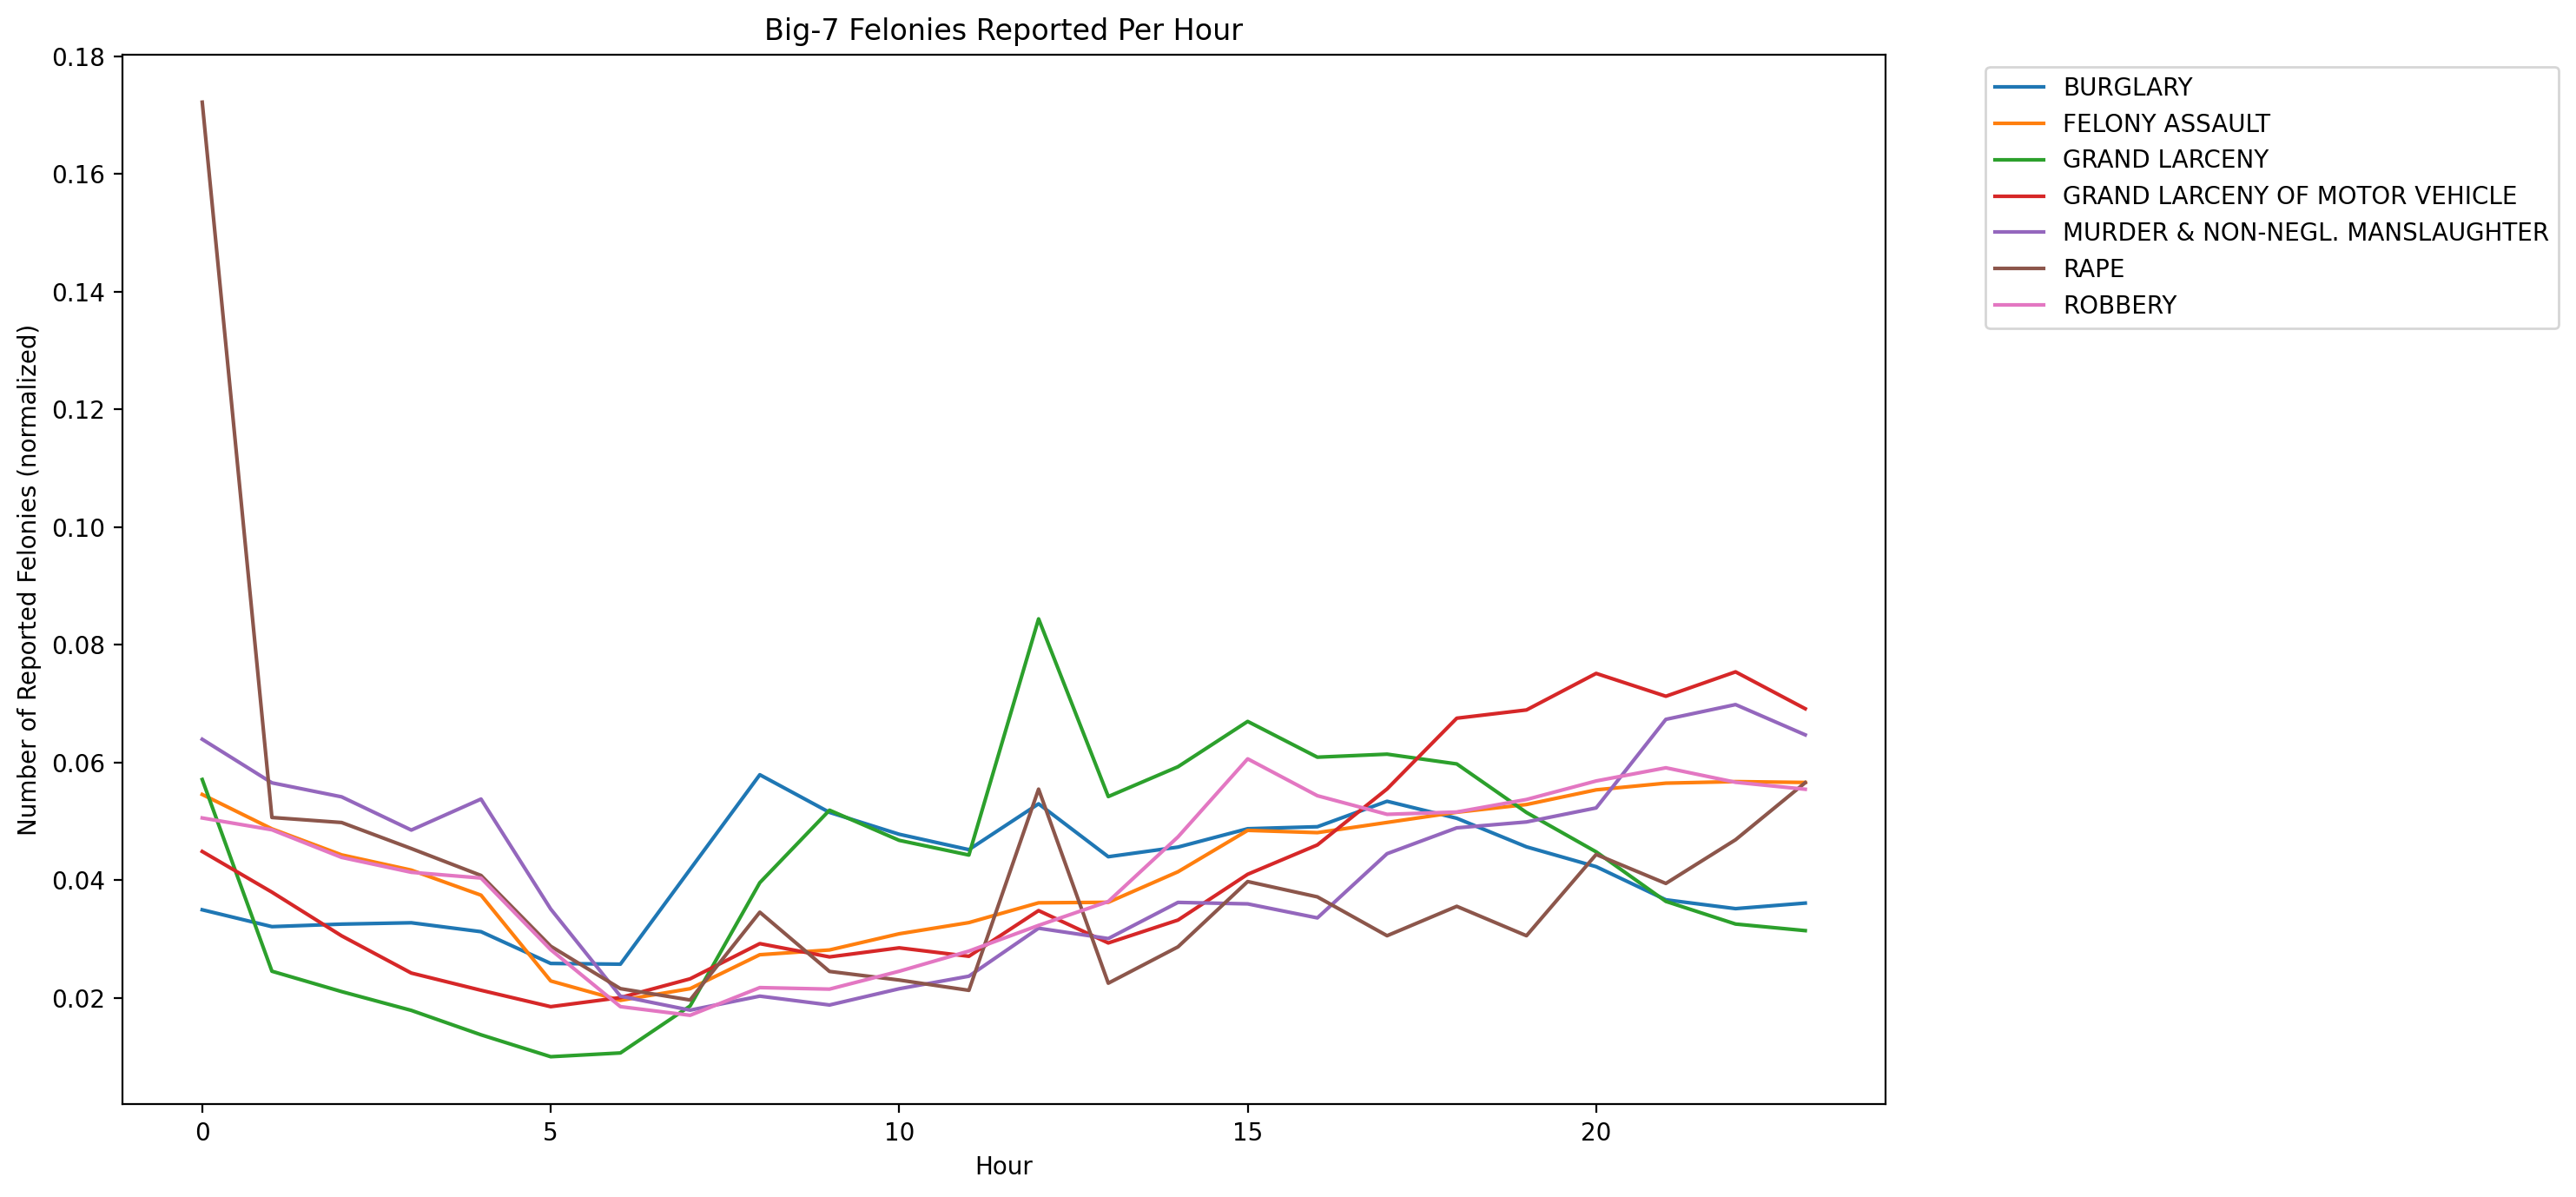

In [118]:
# Pivot the dataframe to have OFNS_DESC as columns for plotting
df_hourly_normalized_pivot = df_hourly_normalized.pivot_table(index='crime_hour', columns='OFNS_DESC', values='normalized_reports', fill_value=0)

# Convert the index to datetime for proper sorting
df_hourly_normalized.index = pd.to_datetime(df_hourly_normalized.index)

# Sort by index (hour)
df_hourly_normalized = df_hourly_normalized.sort_index()

# Plotting with log scale on the y-axis
ax = df_hourly_normalized_pivot.plot(kind='line', figsize=(15, 7), logy=False)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Reported Felonies (normalized)")
ax.set_title("Big-7 Felonies Reported Per Hour")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

## Question 5: Spatial Analysis

You are asked to analyze the spatial density for the following types of felonies:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE

Use the `Latitude` and `Longitude` variables from the dataset to identify the location of each crime. (FYI, for victim privacy, the reported rapes and murders do not have geocoding variables associated with them.) **Limit your analysis to  dates in 2024 and to crimes where  `Latitude` and `Longitude` are not NULL .**

**Hint 1**: If you do a 2d density estimation, you can speed up the computation by taking just a sample of the data that you analyze using the `dataframe.sample()` command.

**Hint 2**: If you could like to plot a map of NYC under your density plot, you can use the shapefile of NYC neighborhoods from NYC Open Data. See the code below.

**Hint 3**: You will need to generate 5 different heatmaps, one for each of the five types of felonies listed above.

<Axes: >

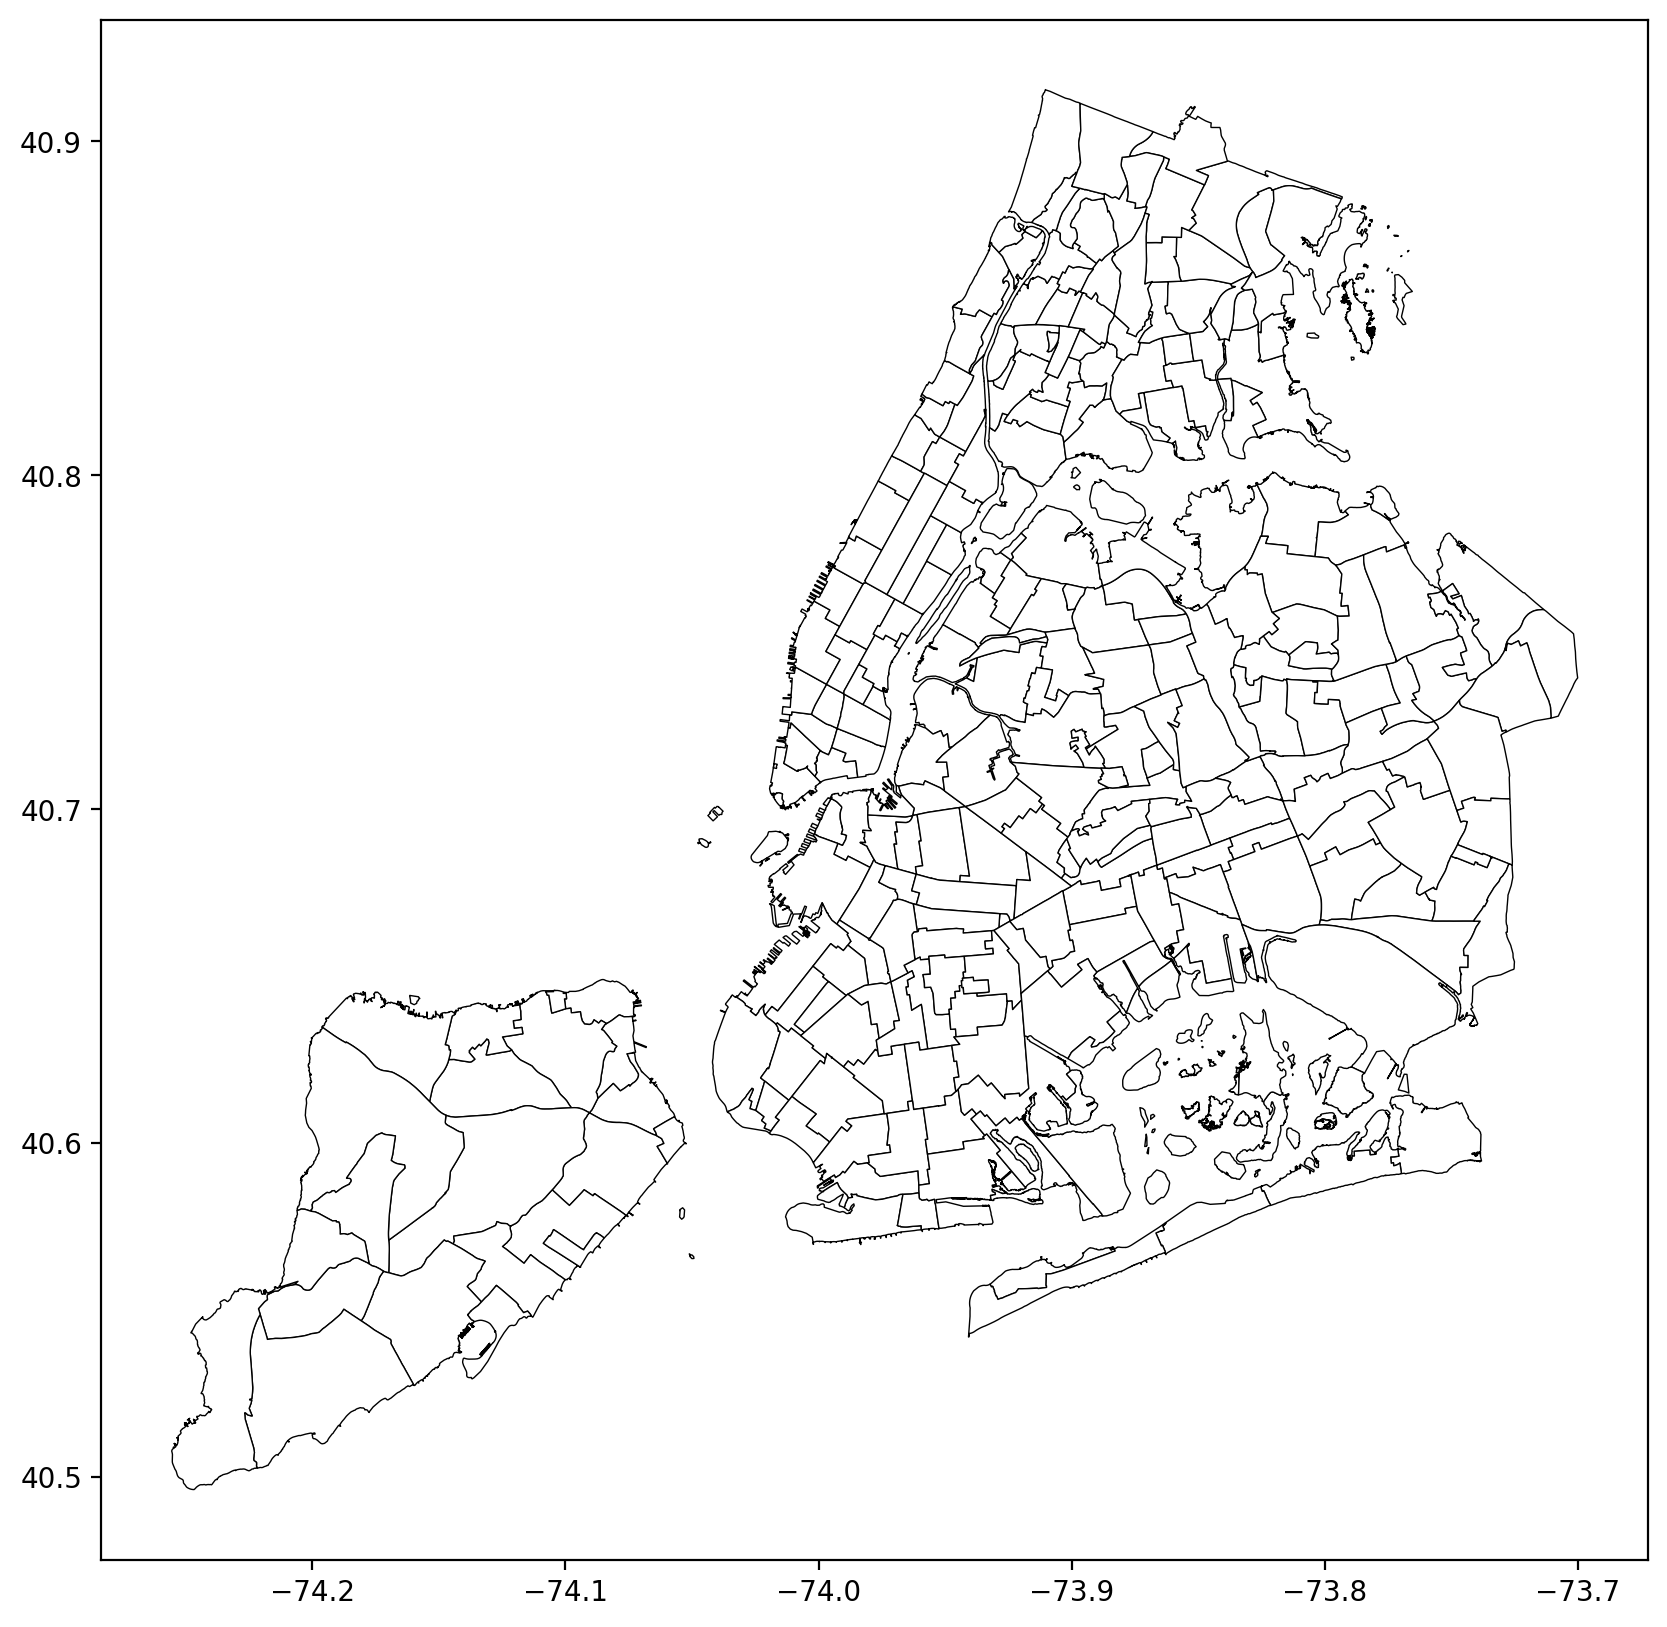

In [119]:
# Dataset from NYC Open Data
shapefile_url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Neighborhood_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'

# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file(shapefile_url)

# Create a plot
df_nyc.plot(linewidth=0.5, color='White', edgecolor='Black', figsize=(15, 10))

In [108]:
sql = '''
SELECT
    nypd.offense_codes.OFNS_DESC,
    nypd.nypd.Latitude,
    nypd.nypd.Longitude
FROM
    nypd.nypd
JOIN
    nypd.offense_codes ON nypd.nypd.KY_CD = nypd.offense_codes.KY_CD
WHERE
    nypd.nypd.LAW_CAT_CD = 'FELONY'
    AND nypd.nypd.CMPLNT_FR BETWEEN '2024-01-01' AND '2024-12-31'
    AND nypd.nypd.Latitude IS NOT NULL
    AND nypd.nypd.Longitude IS NOT NULL
    AND nypd.offense_codes.OFNS_DESC IN (
        'GRAND LARCENY',
        'ROBBERY',
        'FELONY ASSAULT',
        'BURGLARY',
        'GRAND LARCENY OF MOTOR VEHICLE'
    );
'''

with engine.connect() as connection:
        df_spatial = pd.read_sql(text(sql), con=connection)

df_spatial

OFNS_DESC   Latitude  Longitude
0                        GRAND LARCENY  40.756568 -73.990276
1                        GRAND LARCENY  40.757232 -73.989792
2                             BURGLARY  40.850266 -73.915740
3                             BURGLARY  40.727078 -73.825745
4       GRAND LARCENY OF MOTOR VEHICLE  40.754556 -73.853625
...                                ...        ...        ...
118054                   GRAND LARCENY  40.865038 -73.926946
118055                         ROBBERY  40.688406 -73.931642
118056                  FELONY ASSAULT  40.603697 -73.749114
118057                         ROBBERY  40.827766 -73.889959
118058                         ROBBERY  40.749720 -73.864184

[118059 rows x 3 columns]

In [ ]:
#YOUR CODE HERE

Processing: BURGLARY


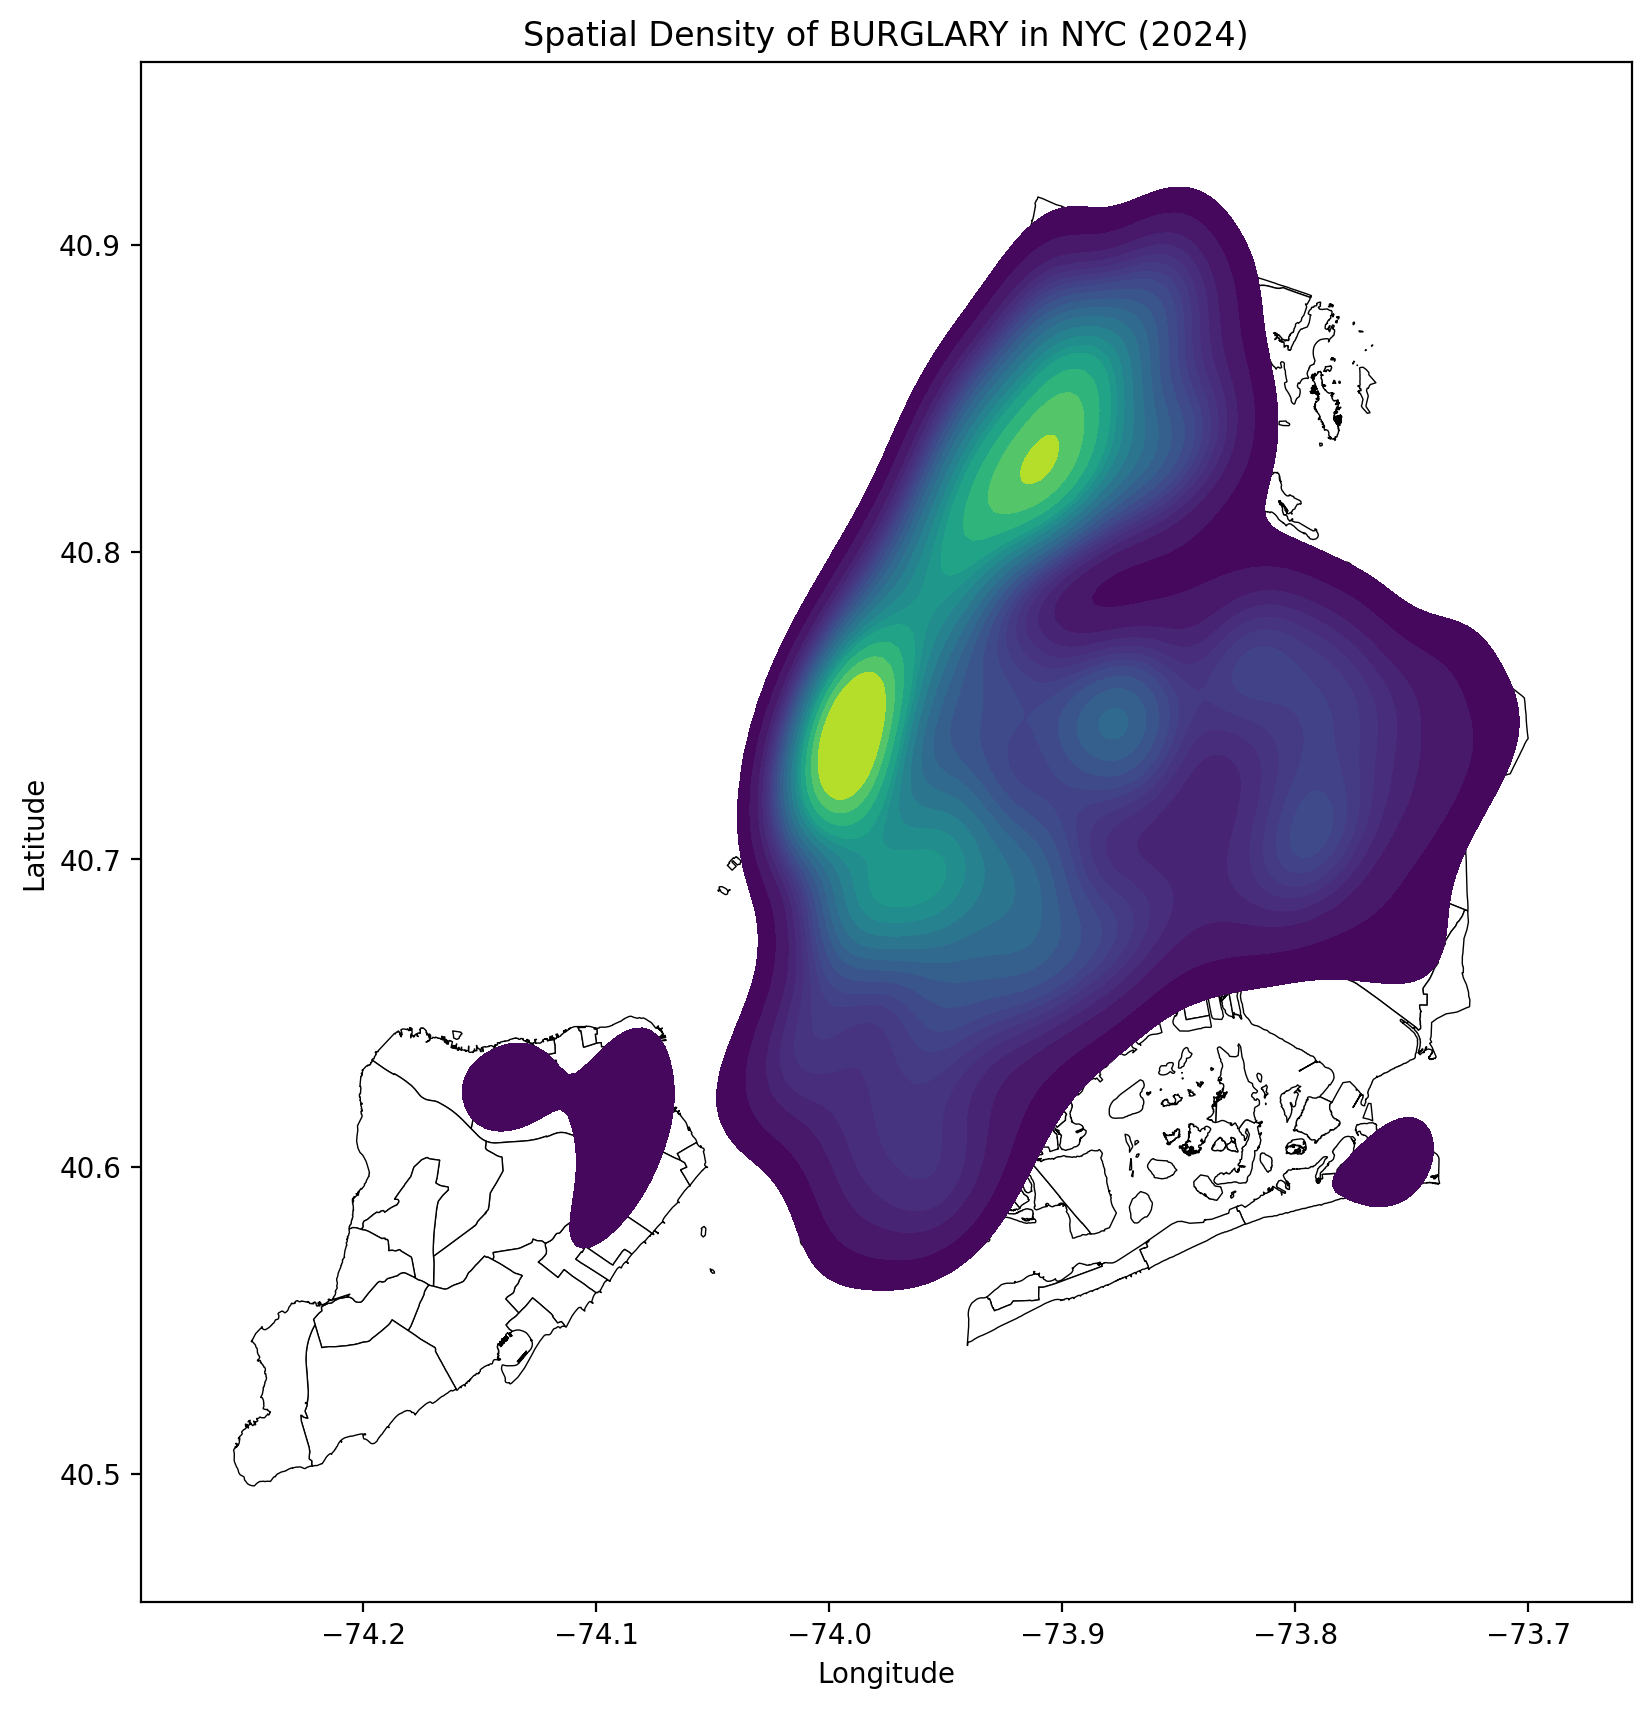

Processing: FELONY ASSAULT


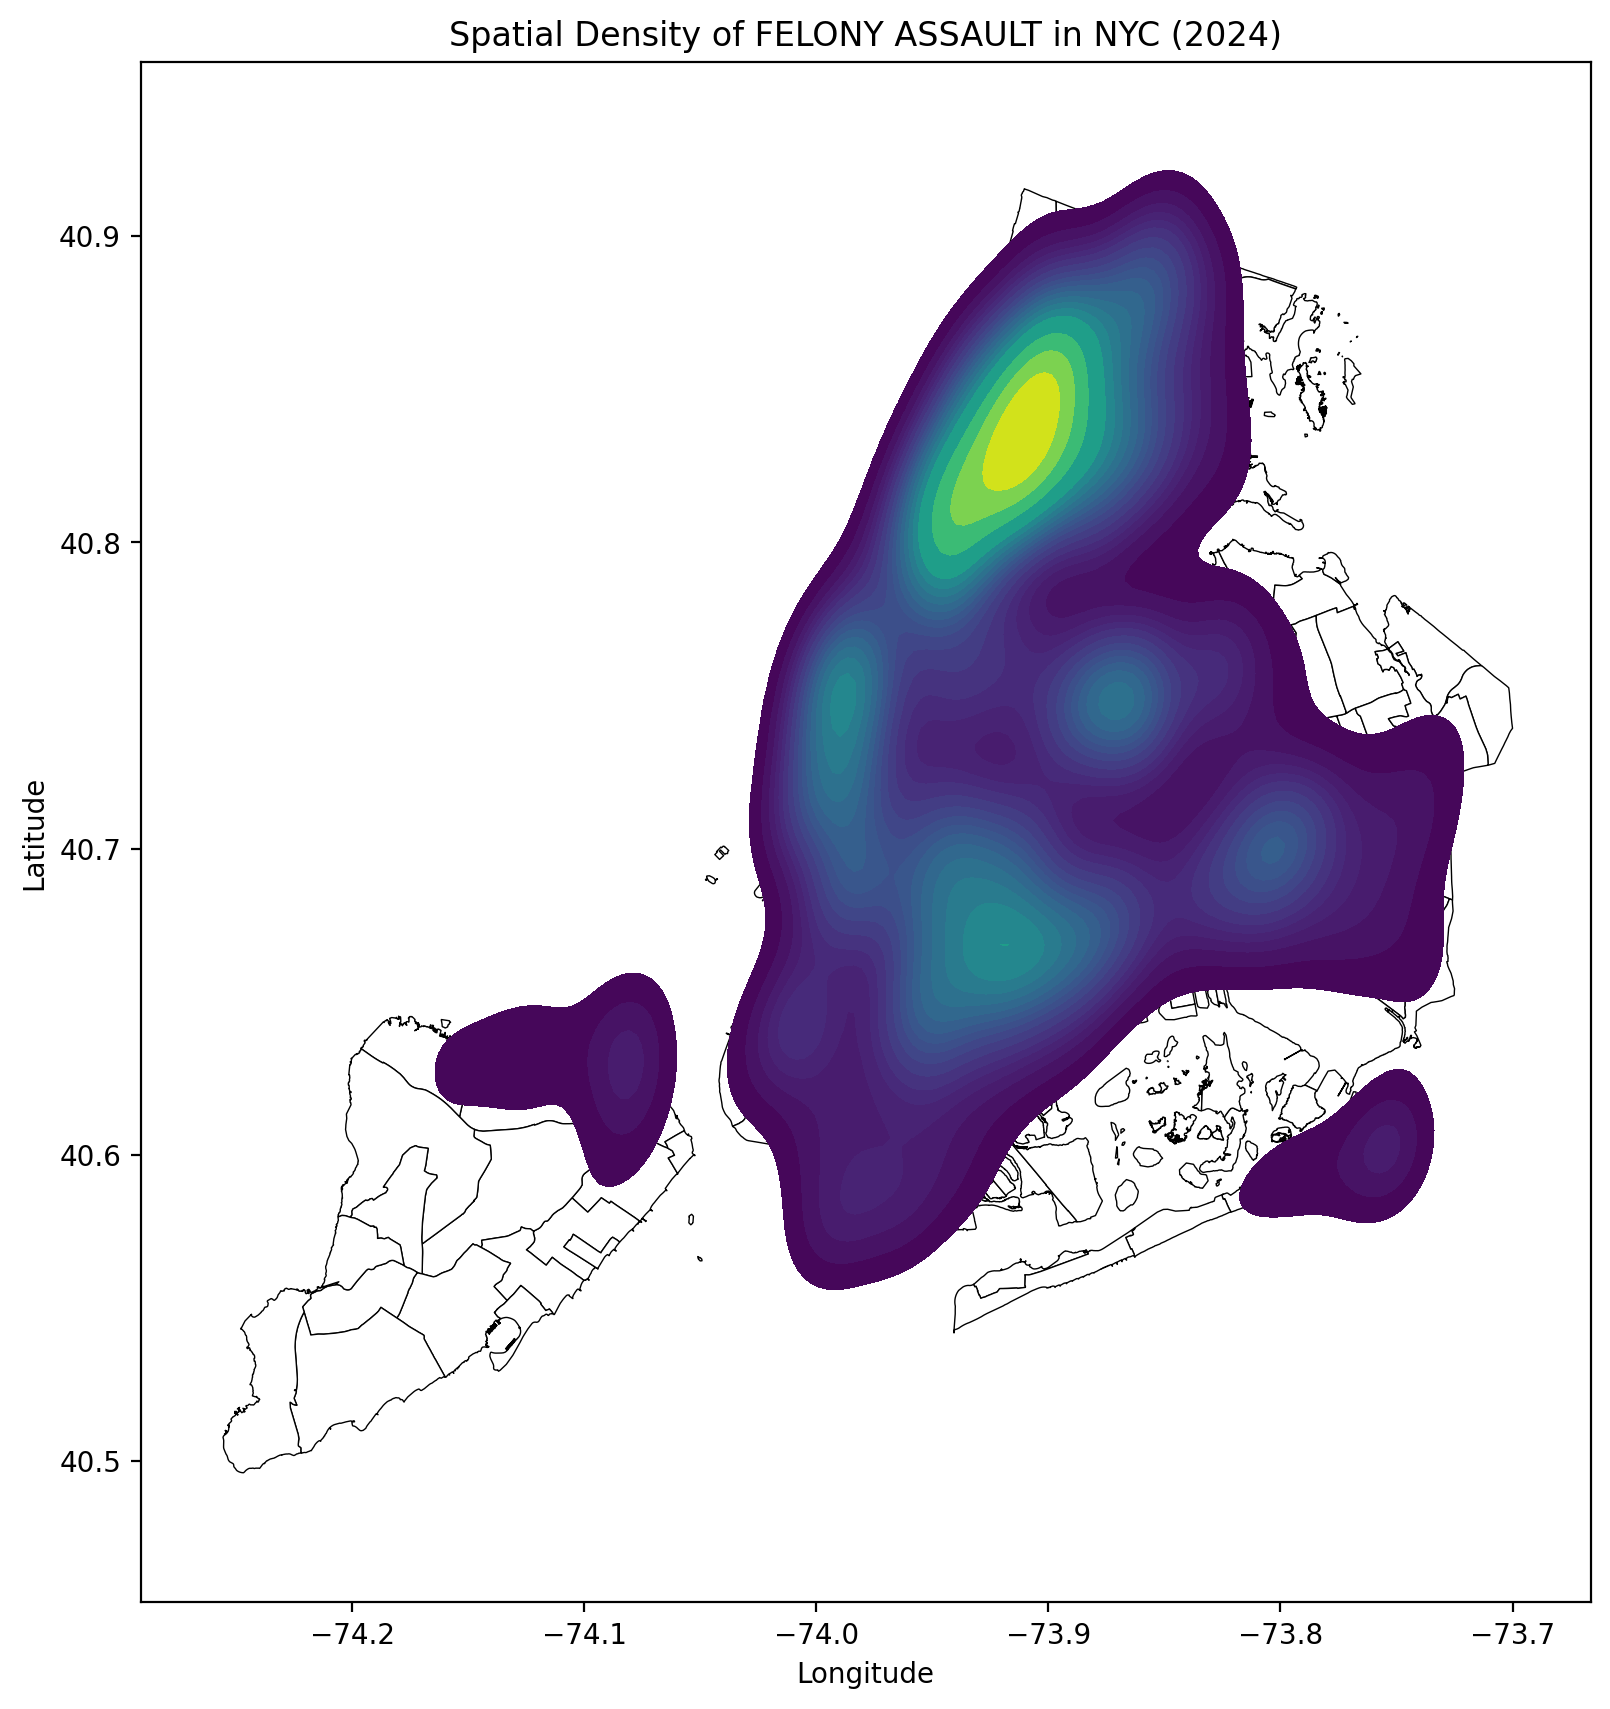

Processing: GRAND LARCENY


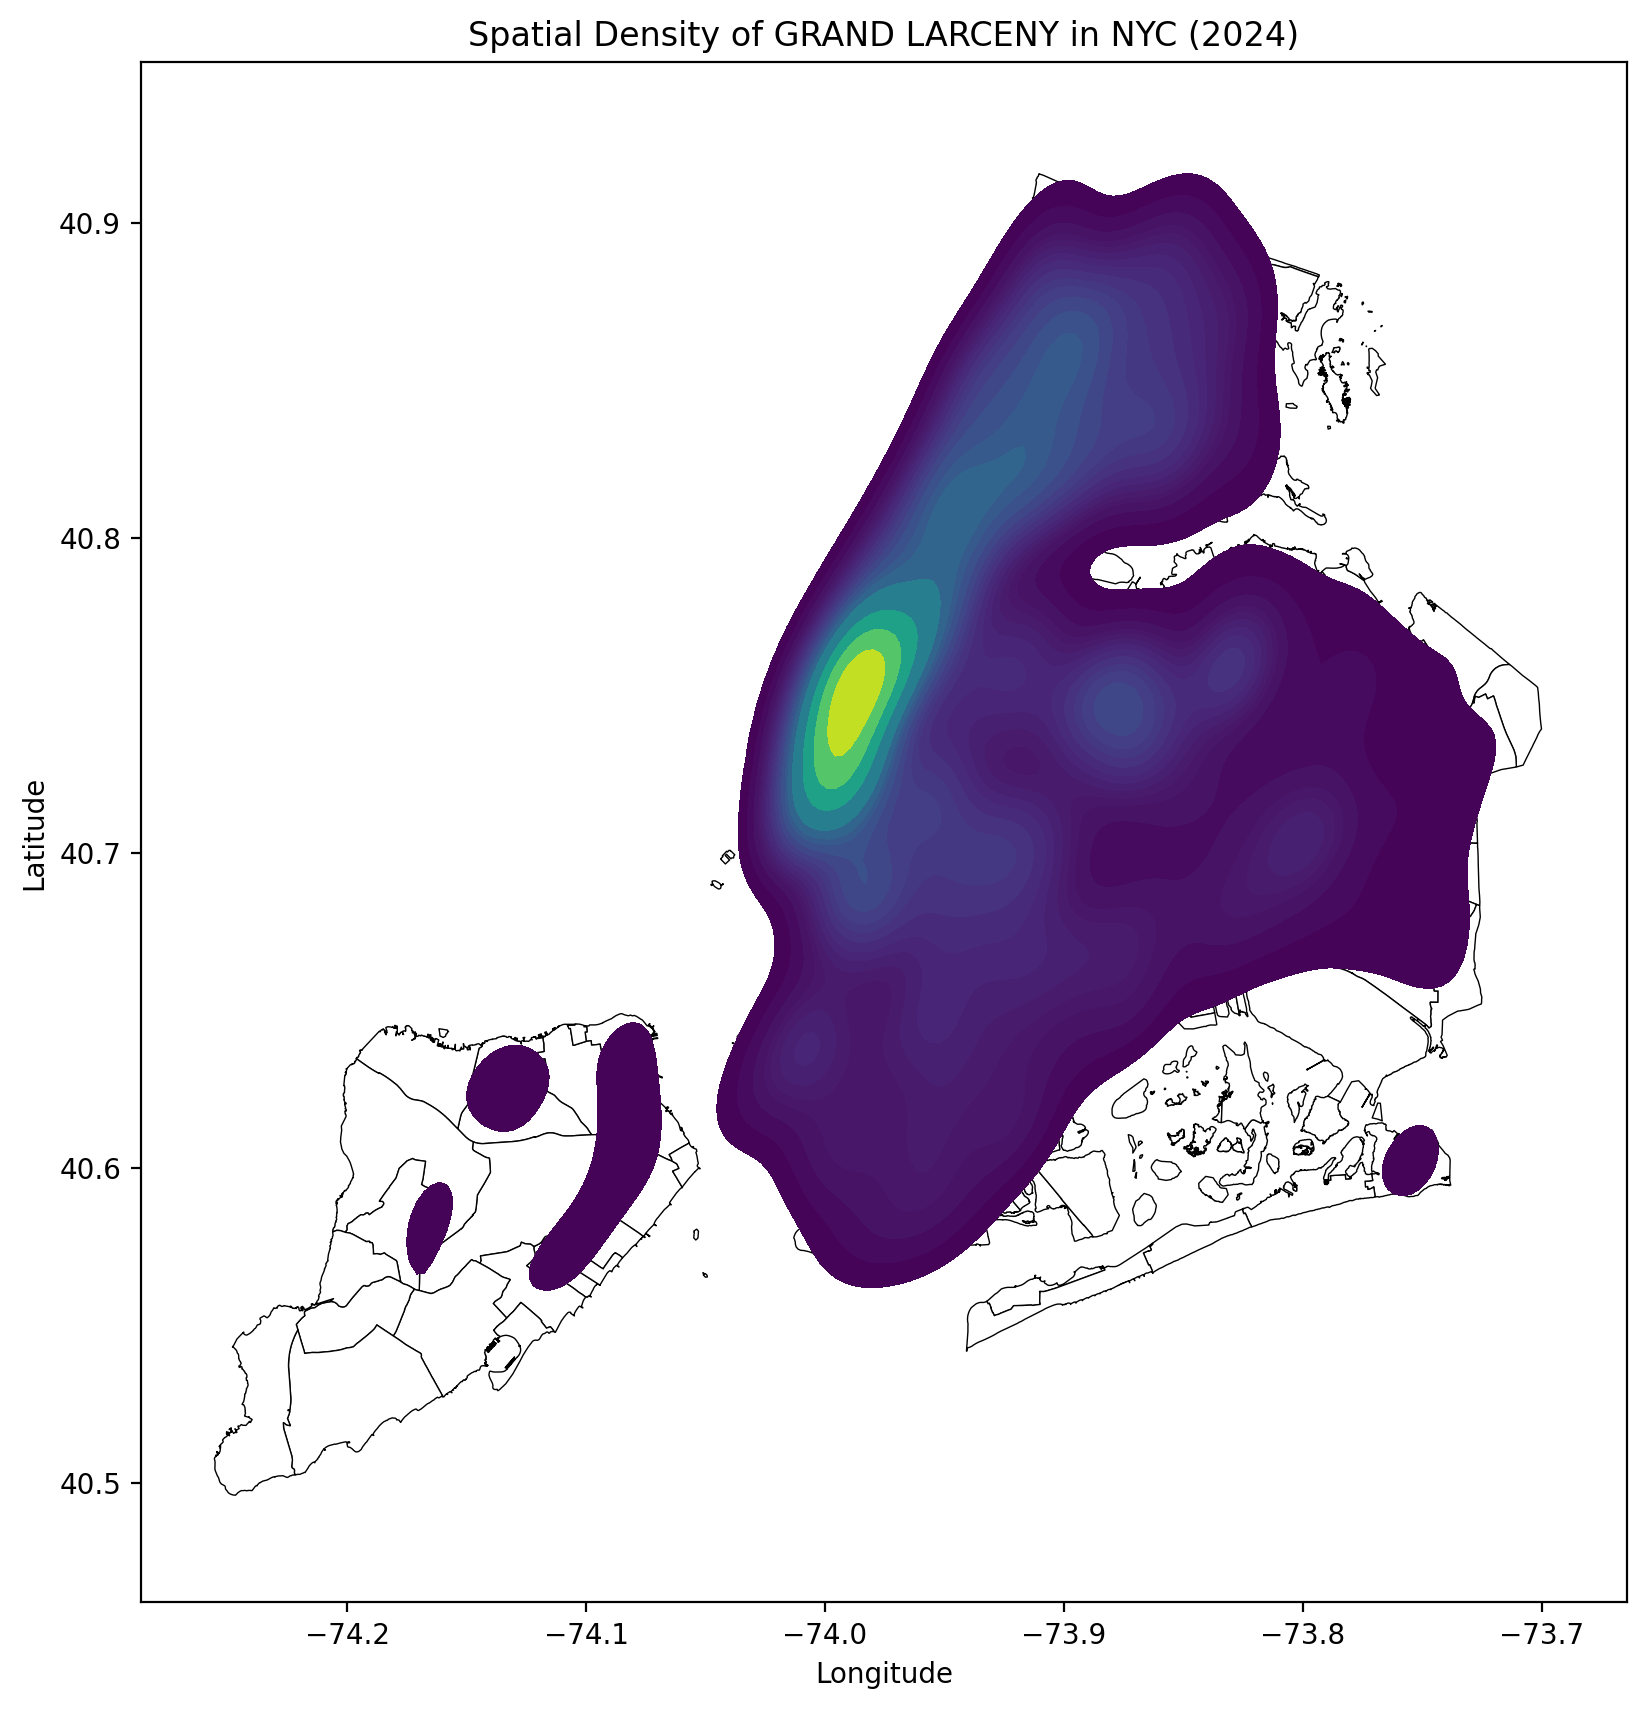

Processing: GRAND LARCENY OF MOTOR VEHICLE


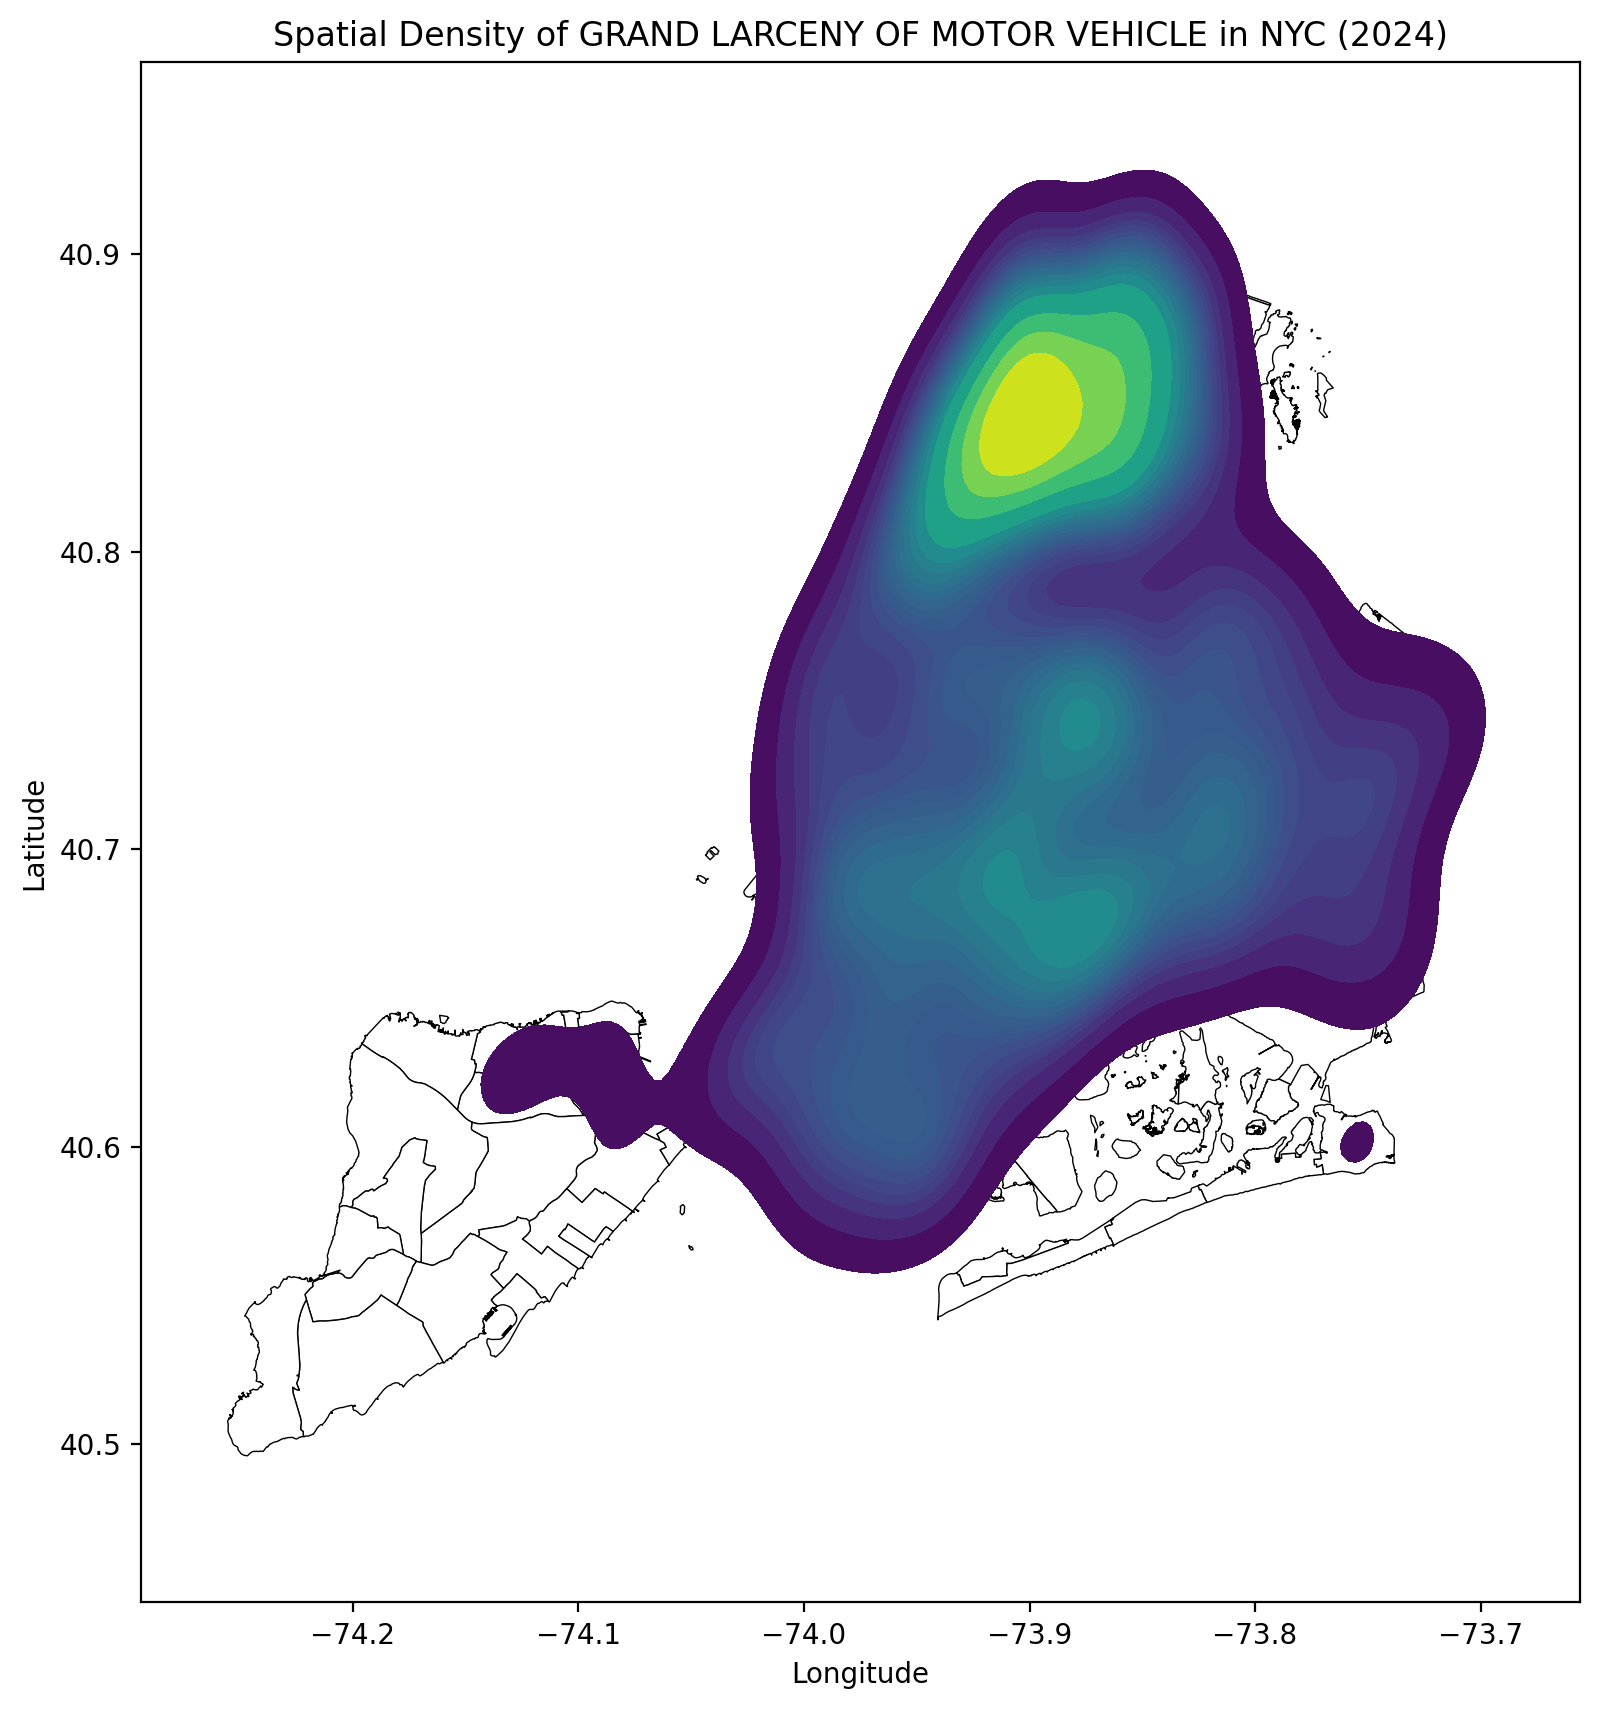

Processing: ROBBERY


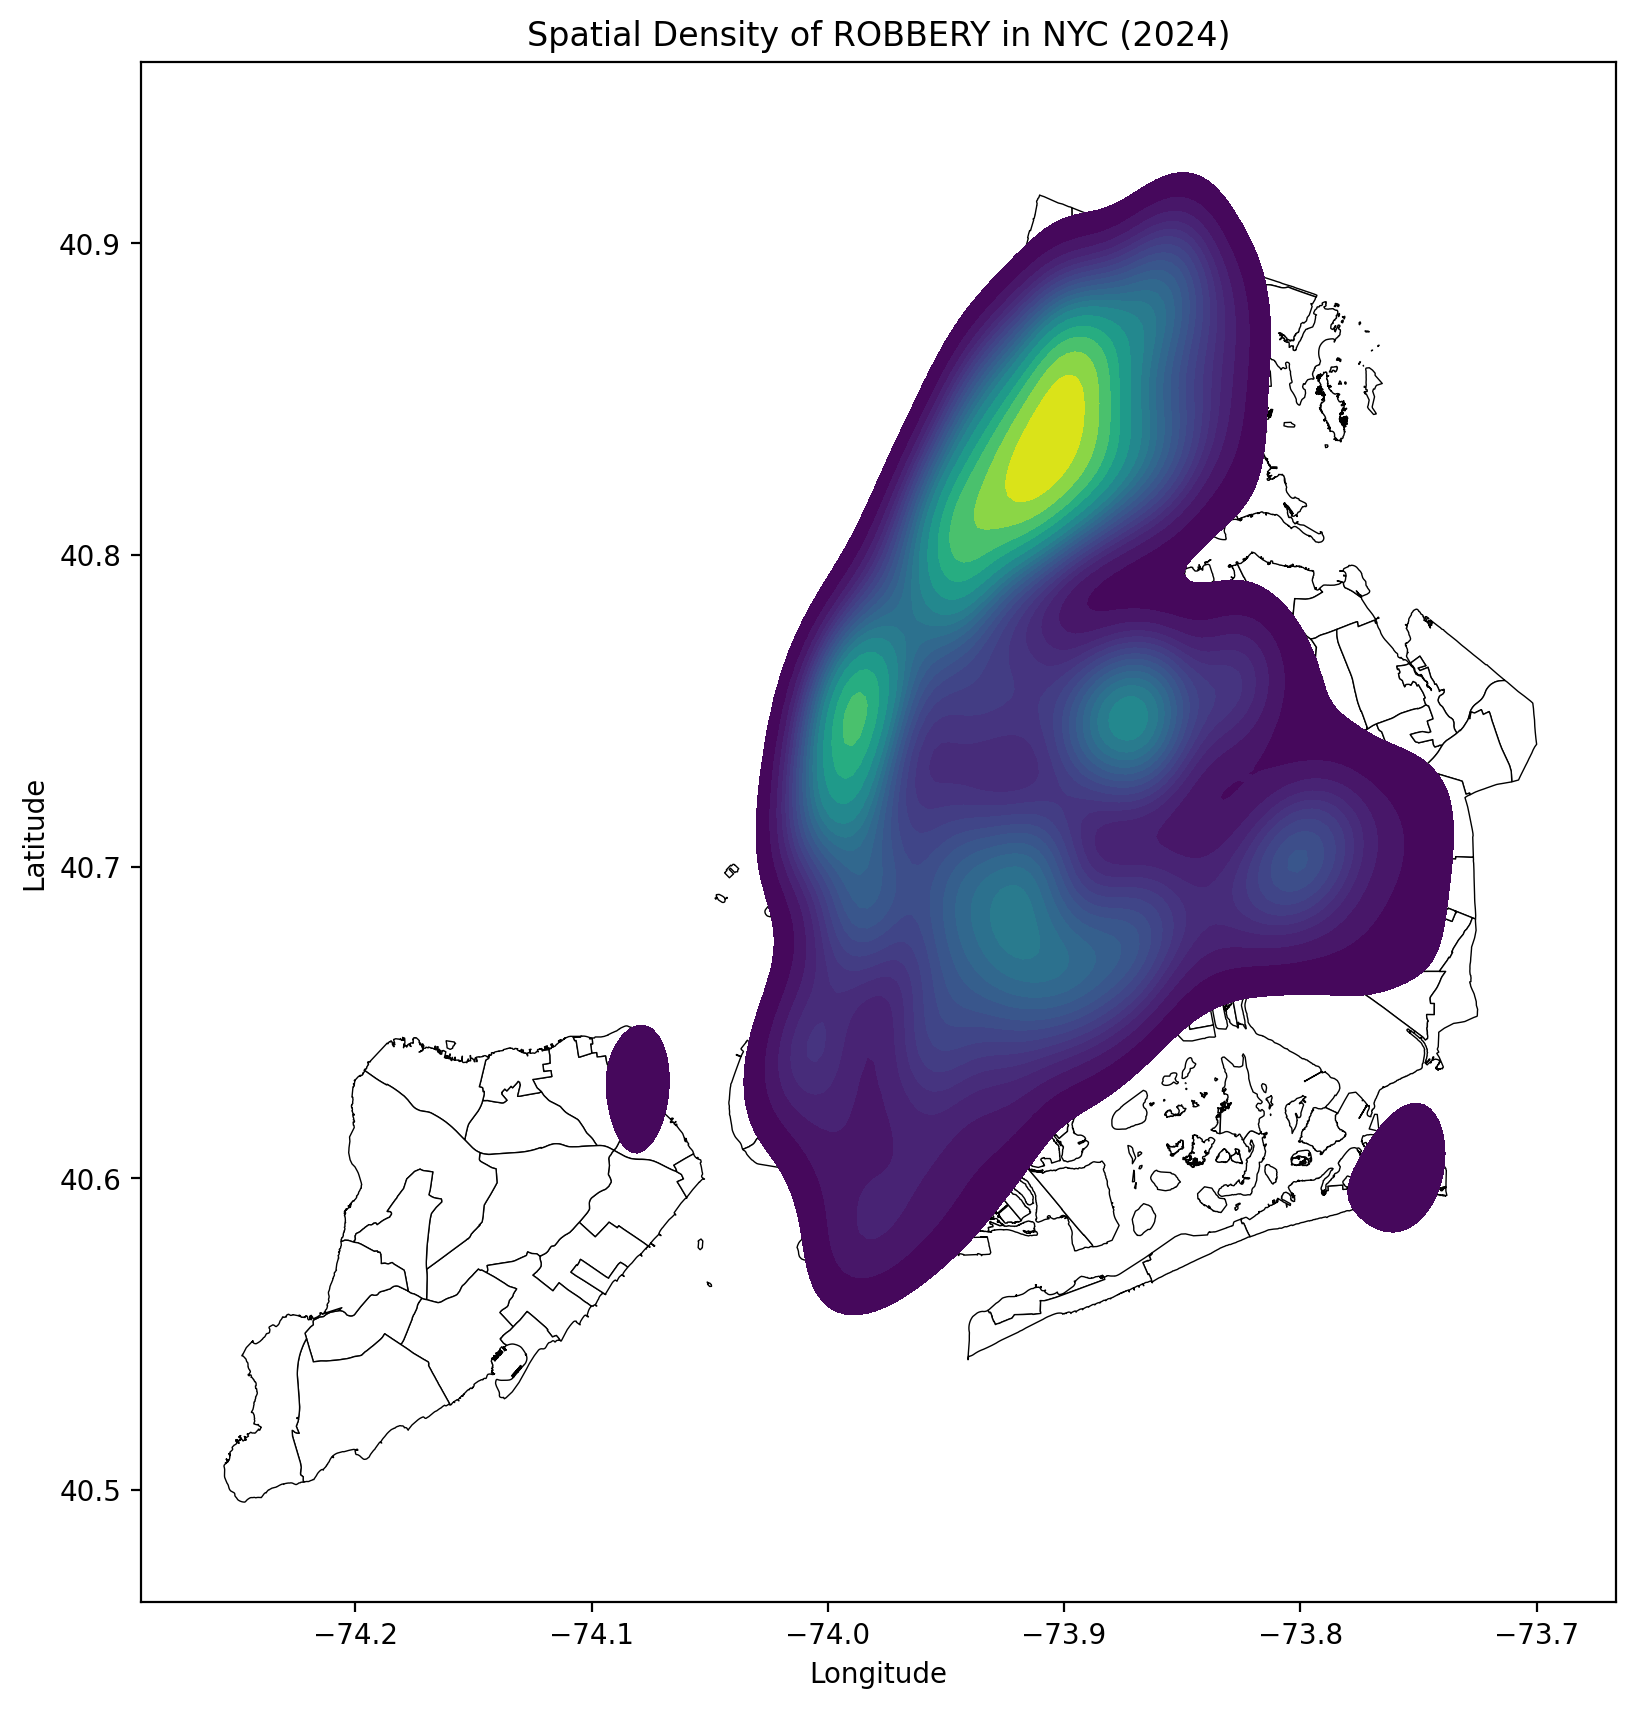

In [120]:
# prompt: Use the Latitude and Longitude variables from the dataset to identify the location of each crime.

import matplotlib.pyplot as plt
# Group the DataFrame by OFNS_DESC
grouped = df_spatial.groupby('OFNS_DESC')

# Iterate over each felony type
for offense, data in grouped:
    print(f"Processing: {offense}")

    # Check if there are enough data points for density plot
    if len(data) < 2:
        print(f"Skipping {offense}: Not enough data points for density plot.")
        continue

    # Create a base plot with the NYC map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    df_nyc.plot(linewidth=0.5, color='White', edgecolor='Black', ax=ax)

    # Plot the density of crime locations
    sns.kdeplot(x=data['Longitude'], y=data['Latitude'], fill=True, cmap="viridis", ax=ax, levels=20)

    ax.set_title(f'Spatial Density of {offense} in NYC (2024)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
